# Compare TSI and Ecotech data: 

In [1]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np
import itertools
from sklearn import datasets, linear_model

import sys

script_path = r'C:\Users\DominicHeslinRees\Documents\ACP_2023\scripts'

sys.path.append(script_path+'\\neph_functions')
import functions as fu

%load_ext autoreload
%autoreload 2

In [2]:
savepath = "C:\\Users\\DominicHeslinRees\\Documents\\ACP_2023\\Analysis\\Neph" 

In [3]:
loadpath = "C:\\Users\\DominicHeslinRees\\Documents\\Analysis\\Neph\\"
print("load from :"+str(loadpath))

df_noLOD_TSI = pd.read_csv(loadpath+"TSI\\1999_2019\\1999_2019_noLOD.dat", index_col=0, parse_dates=True)
df_LOD_TSI = pd.read_csv(loadpath+"TSI\\1999_2019\\1999_2019_LOD.dat", index_col=0, parse_dates=True)

ecotech_loadpath = "C:\\Users\\DominicHeslinRees\\Documents\\Analysis\\Neph\\ecotech_2023\\"

df_noLOD_ecotech = pd.read_csv(ecotech_loadpath+"noLOD_cleaned_hourly_ecotech_data.dat",
                             index_col=0, parse_dates=True)
df_LOD_ecotech = pd.read_csv(ecotech_loadpath+"LOD_cleaned_hourly_ecotech_data.dat",
                             index_col=0, parse_dates=True)
#LOD TSI files
df_LOD_TSI_2016 = pd.read_csv(loadpath+"TSI\\data_cleaned_using_std_method\\2016_LOD_stdclean.dat", index_col=0, parse_dates=True)
df_LOD_TSI_2017 = pd.read_csv(loadpath+"TSI\\data_cleaned_using_std_method\\2017_LOD_stdclean.dat", index_col=0, parse_dates=True)

df_LOD_TSI_2016

def sort_index(df):
    df = df.sort_index()
    return df

for df in [df_noLOD_TSI, df_LOD_TSI, df_noLOD_ecotech, df_LOD_ecotech, df_LOD_TSI_2016, df_LOD_TSI_2017]:
    df = sort_index(df)
    
date_newPSAP_ends = pd.to_datetime('2016-10-13 08:44:00')

load from :C:\Users\DominicHeslinRees\Documents\Analysis\Neph\


In [4]:
df_noLOD_ecotech.head(2)

scat450   scat525   scat635  bscat450  bscat525  \
datetime                                                                
2018-04-22 14:00:00  8.831231  7.797530  7.296213  1.103997  0.924575   
2018-04-22 16:00:00  9.232571  7.945371  7.241873  1.256525  1.039885   

                     bscat635       p_int      T_int     RH_int  \
datetime                                                          
2018-04-22 14:00:00  0.882805  945.129627  24.776797  10.952572   
2018-04-22 16:00:00  0.858126  945.320874  25.066612  10.690546   

                     scat450_count  ...    AE_525    AE_635   scat550  \
datetime                            ...                                 
2018-04-22 14:00:00             51  ...  0.554447  0.349328  7.510026   
2018-04-22 16:00:00             61  ...  0.705208  0.487364  7.593385   

                     bscat550   scat530  bscat530   scat700  bscat700  \
datetime                                                                
2018-04-22 14:00:00  7.510026  7.738070  7.738070  6.912433  6.912433   
2018-04-22 16:00:00  7.593385  7.872352  7.872352  6.760883  6.760883   

                      scat637  bscat637  
datetime                                 
2018-04-22 14:00:00  7.283503  7.283503  
2018-04-22 16:00:00  7.225831  7.225831  

[2 rows x 26 columns]

In [5]:
def day_offset(df, number_of_days=1, split_time=None, add=True, substract=False):
    """Add or subtract days from index"""    
    print(len(df.index))
    if split_time != None: 
        before = df.loc[(df.index < pd.to_datetime(split_time))].index
        if add == True:
            print("Day added: "+str(number_of_days)+' from '+str(split_time))
            times = df.loc[(df.index >= pd.to_datetime(split_time))].index
            print(times[0])
            after = times + pd.DateOffset(days=number_of_days)
            print(after[0])
            df.index = list(before) + list(after)
        print(len(df.index))
        if substract == True:
            print("Day substracted: "+str(number_of_days)+' from '+str(split_time))
            after = df.loc[(df.index >= pd.to_datetime(split_time))].index - pd.DateOffset(days=number_of_days)
            df.index = list(before) + list(after) 
            
    if split_time == None:   
        if add == True:
            print("Day added: "+str(number_of_days))
            df.index = df.index + pd.DateOffset(days=number_of_days) #have to manually offset by a day
        if substract == True:
            print("Day substracted: "+str(number_of_days))
            df.index = df.index - pd.DateOffset(days=number_of_days) #have to manually offset by a day         
    return df

In [6]:
TSI = True
ecotech = False
apply_thresholds=False

if TSI == True:
    wavelengths = [450, 550, 700] #B, G, R
    correction_factors = [(1.345, -.146), (1.319, -1.129), (1.279, -.105)] #(a,b) for B Å(B/G), Å(B/R), Å(G/R) No cut
    cols_wavelengths = ['scat450', 'scat550', 'scat700']
    varlist = ['scat450', 'scat550', 'scat700','bscat450','bscat550','bscat700', 'p_int', 'T_int', 'RH_int']
    detection_limits = [0.29, 0.11, 0.17,0.19, 0.07, 0.11] #5 minutes
if ecotech == True:
    wavelengths = [450, 525, 635] #B, G, R
    correction_factors = [(1.455, -.189), (1.434, -0.176), (1.403, -.156)]
    cols_wavelengths = ['scat450', 'scat525', 'scat635']  
    detection_limits = [0.10, 0.13, 0.11, 0.09, 0.11, 0.12] #post averaging of five minute moving average
    varlist = ['scat450', 'scat525', 'scat635','bscat450','bscat525','bscat635', 'p_int', 'T_int', 'RH_int']

def calculate_AE(df, colour1, colour2, AE_name, bscat=''):
    colour_to_wavelength = {'blue':wavelengths[0], 'green':wavelengths[1], 'red':wavelengths[2]}
    colour_to_CF = {'blue':correction_factors[0], 'green':correction_factors[1], 'red':correction_factors[2]}
    colour_to_col = {'blue':cols_wavelengths[0], 'green':cols_wavelengths[1], 'red':cols_wavelengths[2]}
        
    col1 = colour_to_col[colour1] 
    col2 = colour_to_col[colour2] 
    wavelength1 = colour_to_wavelength[colour1]
    wavelength2 = colour_to_wavelength[colour2]
    AE = -(np.log10(df[col1]/df[col2])/np.log10(wavelength1/wavelength2))
    df[str(bscat)+'AE_'+str(colour_to_wavelength[AE_name])] = AE
    return df

def calculate_all_AEs(df): #blue (450), green (550), red (700)
    df = calculate_AE(df, colour1='blue', colour2='green', AE_name='blue') #Angstrom Exponent at 450nm
    df = calculate_AE(df, colour1='blue', colour2='red', AE_name='green')   #Angstrom Exponent at 550nm
    df = calculate_AE(df, colour1='green', colour2='red', AE_name='red')  #Angstrom Exponent at 700nm
    return df

def convert_wavelength(df, AE_col, scat1, scat2):
    #scat is the wavelength that is wanted 
    #base choice of AE on scat1, 
    
    #if scat1 is blue, AE made from blue i.e. blue and green 
    #if scat1 is green what AE should be used - so choice of two but AE made from green is one (i.e. blue, red)
    #if scat1 is red, AE made from red i.e. green or red 
    scat_converted = df['scat'+str(scat1)]*(scat1/scat2)**df['AE_'+str(AE_col)] #scat550 = df_AE.scat525*(525/550)**AE_525
    df['scat'+str(scat2)] = scat_converted
    return df

In [7]:
df_LOD_TSI_2016 = calculate_all_AEs(df_LOD_TSI_2016)
df_LOD_TSI_2017 = calculate_all_AEs(df_LOD_TSI_2017)

print(df_LOD_TSI_2016.columns)

Index(['scat450', 'scat550', 'scat700', 'p_int', 'T_int', 'RH_int', 'Flag',
       'AE_450', 'AE_550', 'AE_700'],
      dtype='object')


In [8]:
df_LOD_TSI_2016 = convert_wavelength(df_LOD_TSI_2016, AE_col=450, scat1=550, scat2=525)
df_LOD_TSI_2016 = convert_wavelength(df_LOD_TSI_2016, AE_col=450, scat1=550, scat2=530)
df_LOD_TSI_2016 = convert_wavelength(df_LOD_TSI_2016, AE_col=550, scat1=700, scat2=635)
df_LOD_TSI_2016 = convert_wavelength(df_LOD_TSI_2016, AE_col=550, scat1=700, scat2=637)

df_LOD_TSI_2017 = convert_wavelength(df_LOD_TSI_2017, AE_col=450, scat1=550, scat2=525)
df_LOD_TSI_2017 = convert_wavelength(df_LOD_TSI_2017, AE_col=450, scat1=550, scat2=530)
df_LOD_TSI_2017 = convert_wavelength(df_LOD_TSI_2017, AE_col=550, scat1=700, scat2=635)
df_LOD_TSI_2017 = convert_wavelength(df_LOD_TSI_2017, AE_col=550, scat1=700, scat2=637)

In [9]:
df_LOD_TSI['std_cleaned_data'] = 0;  df_LOD_TSI_2016['std_cleaned_data'] = 1;
df_LOD_TSI_2017['std_cleaned_data'] = 1

df_LOD_TSI_ = pd.concat([df_LOD_TSI, df_LOD_TSI_2016, df_LOD_TSI_2017])
fu.find_number_of_duplicate_indexs(df_LOD_TSI_)

df_first, df_last = fu.remove_duplicates(df_LOD_TSI_)
df_LOD_TSI = df_first.copy()

Duplicate Rows except first occurrence based on all columns are :
4000
Length before: 102530
Duplicate Rows except first occurrence based on all columns are :
4000
DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00',
               '2016-01-01 03:00:00', '2016-01-01 04:00:00',
               '2016-01-01 05:00:00', '2016-01-01 06:00:00',
               '2016-01-01 07:00:00', '2016-01-01 08:00:00',
               '2016-01-01 09:00:00', '2016-01-01 10:00:00',
               ...
               '2016-12-31 14:00:00', '2016-12-31 15:00:00',
               '2016-12-31 16:00:00', '2016-12-31 17:00:00',
               '2016-12-31 18:00:00', '2016-12-31 19:00:00',
               '2016-12-31 20:00:00', '2016-12-31 21:00:00',
               '2016-12-31 22:00:00', '2016-12-31 23:00:00'],
              dtype='datetime64[ns]', name='date', length=4000, freq=None)
Length after: 98530
Length after: 98530


In [10]:
fu.save_df(df_LOD_TSI, path=savepath, name='df_LOD_TSI') 

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_LOD_TSI.dat


In [11]:
def thickax(ax):
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.3)
        ax.spines[axis].set_color('k')
    plt.rc('axes', linewidth=0.2)
    fontsize = 12
    ax = plt.gca()
    for tick in ax.xaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label1.set_fontsize(fontsize)
    ax.tick_params(direction='out', length=8, width=1.3, pad=10, bottom=True, top=False, left=True, right=False, color='k')
    ax.tick_params(which='minor', length=4, color='k', width=1.3)

In [12]:
def find_top_both_quantiles(df, var, percentile_value=0.95):
    df = df.copy()
    df[var] = df[var].replace([np.inf, -np.inf], np.nan).dropna(how='all')
    qtop = np.nanquantile(df[var].values, percentile_value)
    qbottom = np.nanquantile(df[var].values, 1-percentile_value)
    return qtop, qbottom

In [13]:
def basic_timeseries_plot(df, var, instrument='TSI', wavelength=' ', legendlabel='detection limits', startdate=None,
                         enddate=None, monthly=False, savepath=None, savename='default', ms=0.5, mec='k', 
                         percentile_value=0.99, ax=None):   
    label = '$\sigma_{\mathrm{sp}}$ ('+str(instrument)+','+str(wavelength)+' nm) [Mm$^{-1}$]'
    
    produce_fig = False
    if ax == None:
        fig, ax = plt.subplots(figsize=(20,6))
        produce_fig = True
        
    qtop, qbottom = find_top_both_quantiles(df, var, percentile_value)
    print(qtop, qbottom)
    
    ax.plot(df.index, df[var],'o',ms=ms, label=legendlabel, mec=mec, mfc='None')
    ax.set_ylabel(label, fontsize=25)
    ax.legend(fontsize=15, markerscale=1., frameon=False, loc=1)
    ax.set_ylim(qbottom,qtop)
    ax.set_xlim(pd.to_datetime(startdate), pd.to_datetime(enddate))
    
    thickax(ax)    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=20, direction='in') #, rotation=45)
    ax.tick_params(axis='both', which='minor', labelsize=20, direction='in') #, rotation=45)
    ax.grid(True, alpha=0.5)     

    if monthly == True:
        df_resampled = df[var].resample('M').median()
        ax.plot(df_resampled.index, df_resampled.values, 'o-', c='r')
    
    if produce_fig == True:
        plt.show()
        return fig
    if produce_fig == False:
        return ax

21.864126300000024 0.3202244


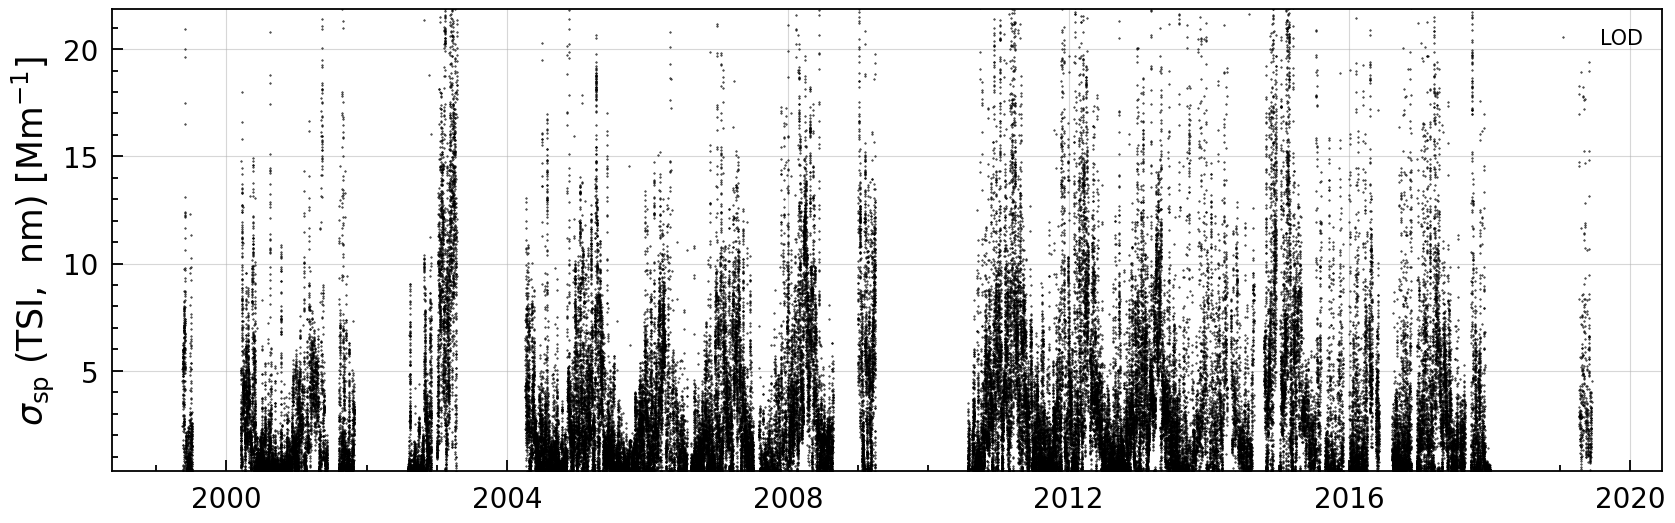

In [14]:
fig = basic_timeseries_plot(df_LOD_TSI, var='scat450',instrument='TSI', legendlabel='LOD', percentile_value=0.99)

## TSI: 

21.864126300000024 0.3202244


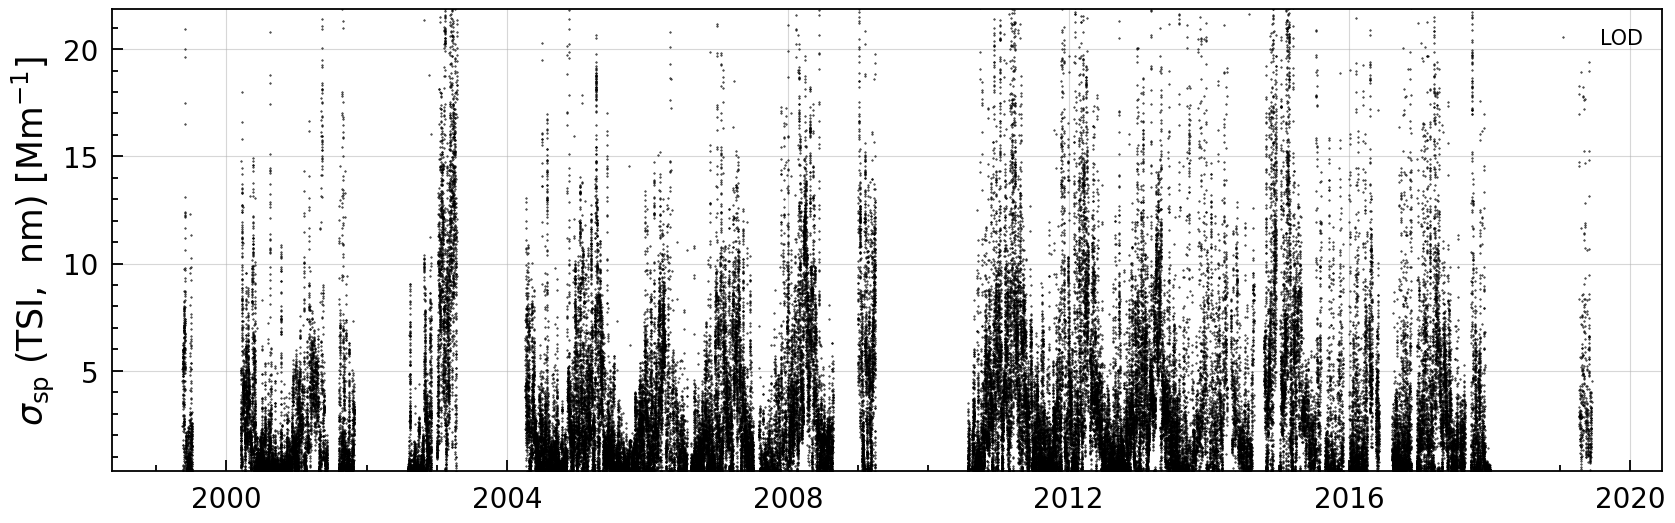

21.281853199999947 -0.4263401999999992


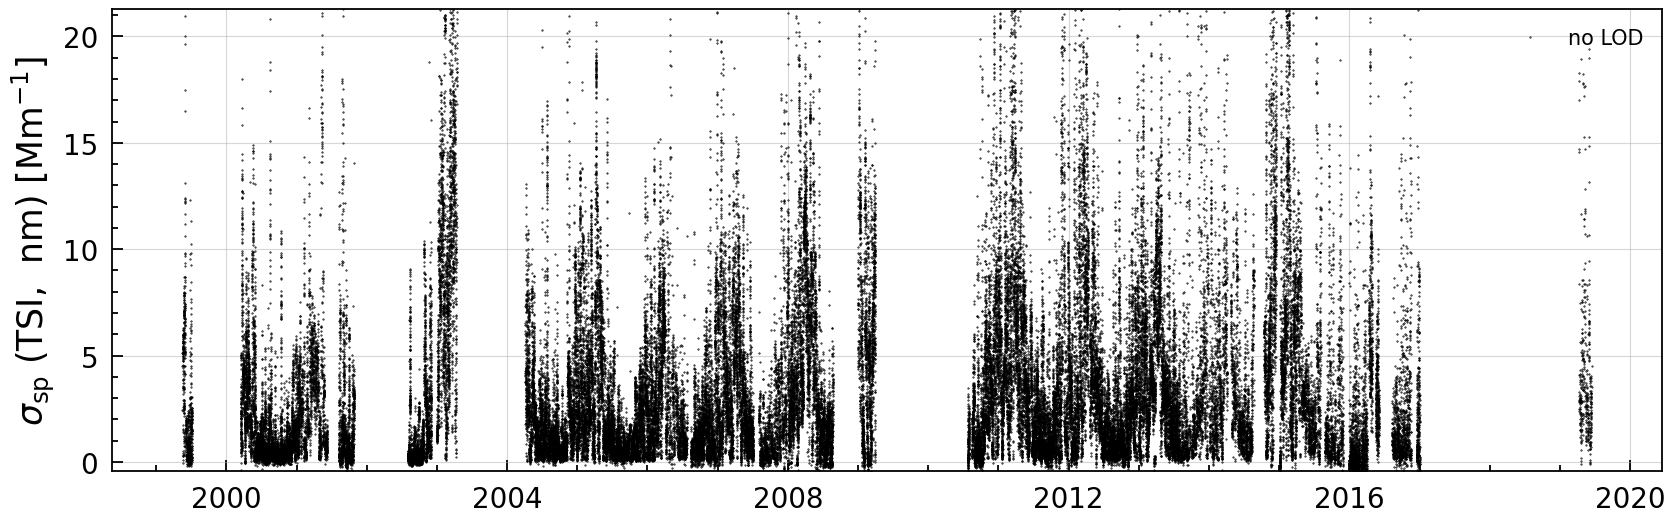

In [15]:
fig = basic_timeseries_plot(df_LOD_TSI, var='scat450',instrument='TSI', legendlabel='LOD')
fig = basic_timeseries_plot(df_noLOD_TSI, var='scat450',instrument='TSI', legendlabel='no LOD')

# ECOTECH: 

42.52148822000001 0.20549381


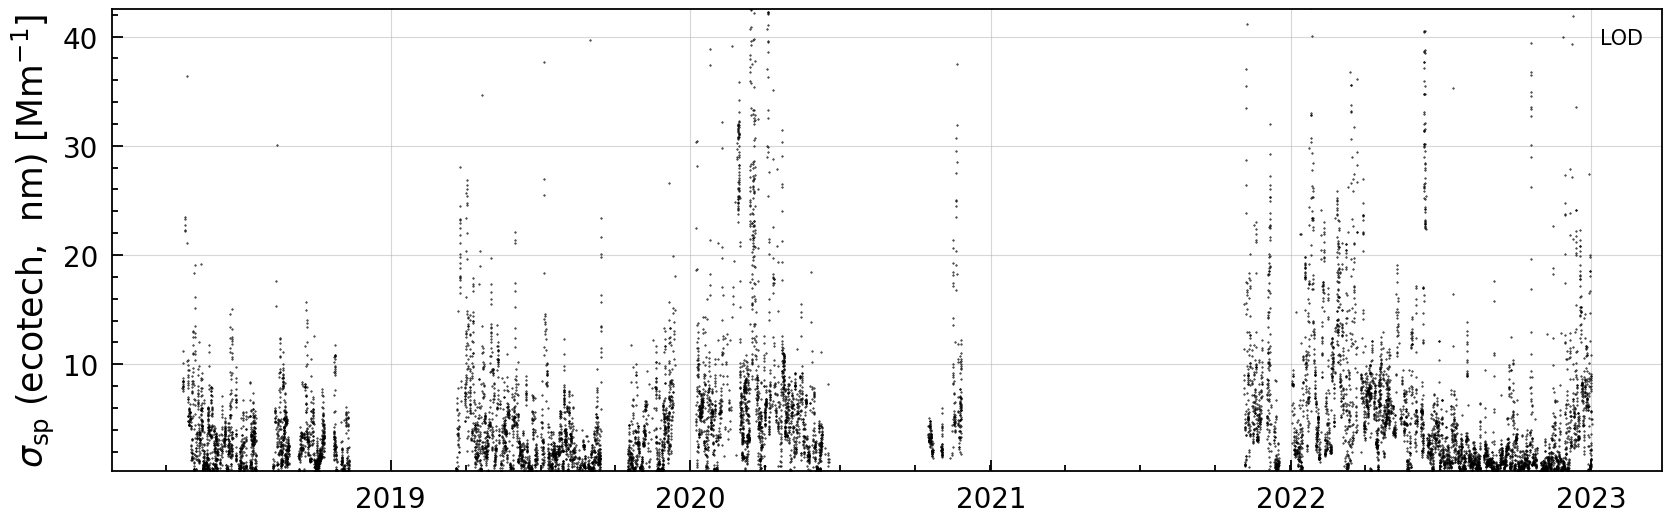

42.18806779999997 -1.3732868


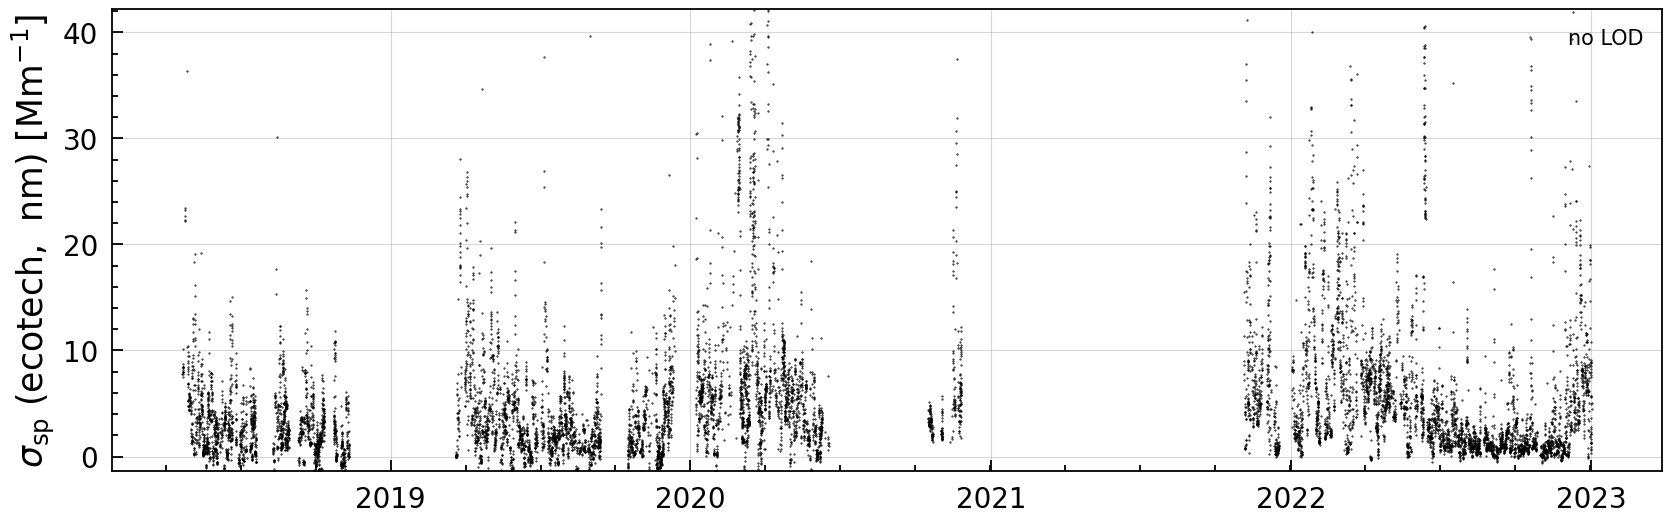

In [16]:
fig = basic_timeseries_plot(df_LOD_ecotech, var='scat525',instrument='ecotech', legendlabel='LOD')
fig = basic_timeseries_plot(df_noLOD_ecotech, var='scat525',instrument='ecotech', legendlabel='no LOD')

## July 2019: 

296
18.66897265000008 0.19107705


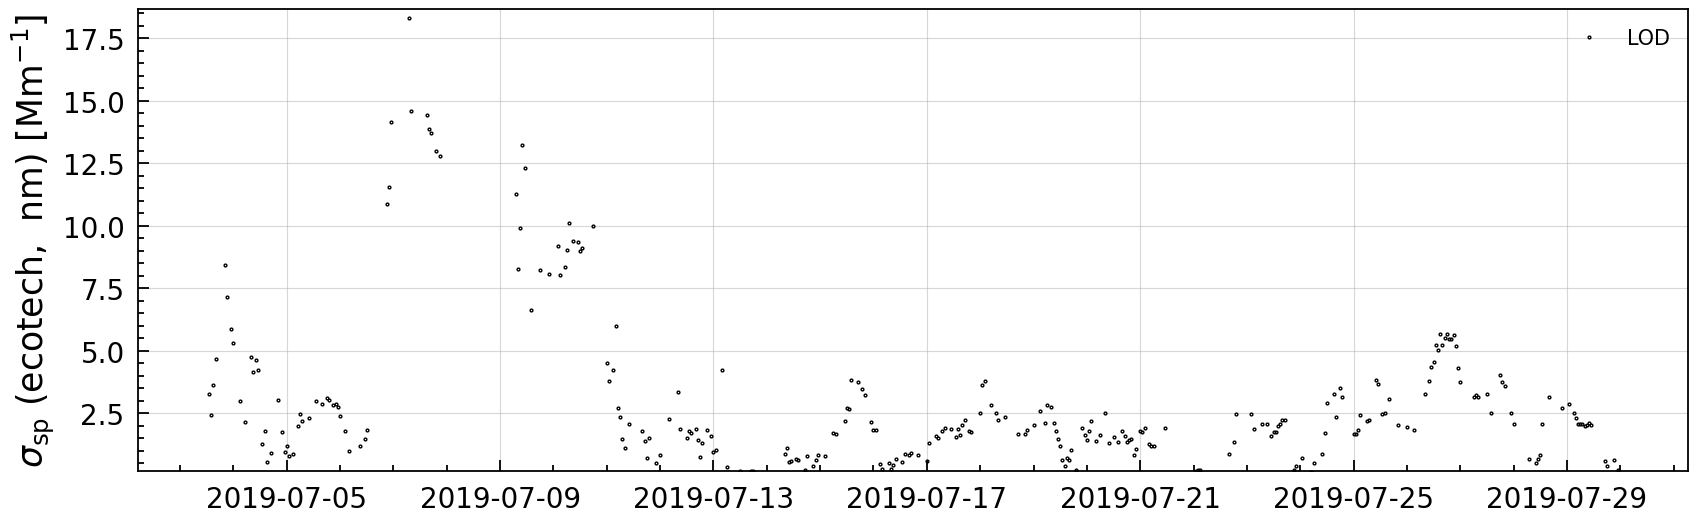

In [17]:
df_LOD_ecotech_july = df_LOD_ecotech['2019-07-01':'2019-07-29'].copy()
print(len(df_LOD_ecotech_july['scat525'].dropna()))
fig = basic_timeseries_plot(df_LOD_ecotech_july, var='scat525',instrument='ecotech', legendlabel='LOD', ms=2)

## LOD ecotech: 

In [18]:
df_LOD_ecotech.head(2)

scat450   scat525   scat635  bscat450  bscat525  \
datetime                                                                
2018-04-22 14:00:00  8.831231  7.797530  7.296213  1.103997  0.924575   
2018-04-22 16:00:00  9.232571  7.945371  7.241873  1.256525  1.039885   

                     bscat635       p_int      T_int     RH_int  \
datetime                                                          
2018-04-22 14:00:00  0.882805  945.129627  24.776797  10.952572   
2018-04-22 16:00:00  0.858126  945.320874  25.066612  10.690546   

                     scat450_count  ...    AE_525    AE_635   scat550  \
datetime                            ...                                 
2018-04-22 14:00:00             51  ...  0.554447  0.349328  7.510026   
2018-04-22 16:00:00             61  ...  0.705208  0.487364  7.593385   

                     bscat550   scat530  bscat530   scat700  bscat700  \
datetime                                                                
2018-04-22 14:00:00  7.510026  7.738070  7.738070  6.912433  6.912433   
2018-04-22 16:00:00  7.593385  7.872352  7.872352  6.760883  6.760883   

                      scat637  bscat637  
datetime                                 
2018-04-22 14:00:00  7.283503  7.283503  
2018-04-22 16:00:00  7.225831  7.225831  

[2 rows x 26 columns]

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
var = 'scat450_count'
basic_timeseries_plot(df_LOD_ecotech, var=var,instrument='ecotech', legendlabel='LOD', ax=ax)
plt.show()

In [20]:
def apply_threshold(df, var, threshold=10):
    df = df.copy()
    df.loc[df[str(var)+'_count'] < threshold, str(var)] = np.nan
    print(len(df))
    df = df.dropna(subset=[var], how='all')
    print(len(df))
    return df

In [21]:
def apply_percentile(df, var, percentile_value=0.99):
    df = df.copy()    
    qtop, qbottom = find_top_both_quantiles(df, var, percentile_value)
    df.loc[df[str(var)] > qtop, str(var)] = np.nan
    df.loc[df[str(var)] < qbottom, str(var)] = np.nan    
    df = df.dropna(subset=[var], how='all')
    return df

In [22]:
if apply_thresholds == True:    
    for var in ['scat450', 'scat525', 'scat635', 'bscat450', 'bscat525', 'bscat635']:
        df_noLOD_ecotech = apply_threshold(df_noLOD_ecotech, var=var)
        df_noLOD_ecotech = apply_percentile(df_noLOD_ecotech, var=var, percentile_value=0.99)

        df_LOD_ecotech = apply_threshold(df_LOD_ecotech, var=var)
        df_LOD_ecotech = apply_percentile(df_LOD_ecotech, var=var, percentile_value=0.99)

296
18.66897265000008 0.19107705


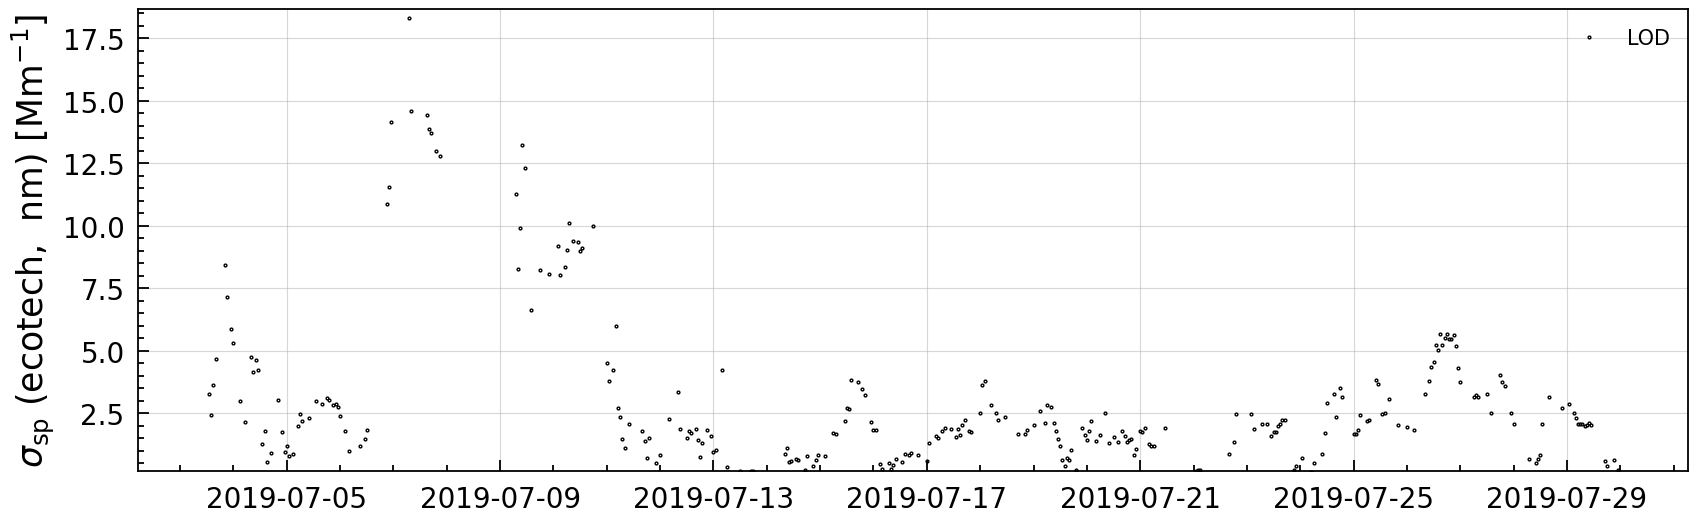

In [23]:
df_LOD_ecotech_july = df_LOD_ecotech['2019-07-01':'2019-07-29'].copy()
print(len(df_LOD_ecotech_july['scat525'].dropna()))
fig = basic_timeseries_plot(df_LOD_ecotech_july, var='scat525',instrument='ecotech', legendlabel='LOD', ms=2)

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
var = 'scat450_count'
basic_timeseries_plot(df_LOD_ecotech, var=var,instrument='ecotech', legendlabel='LOD', ax=ax)
plt.show()

42.52148822000001 0.20549381


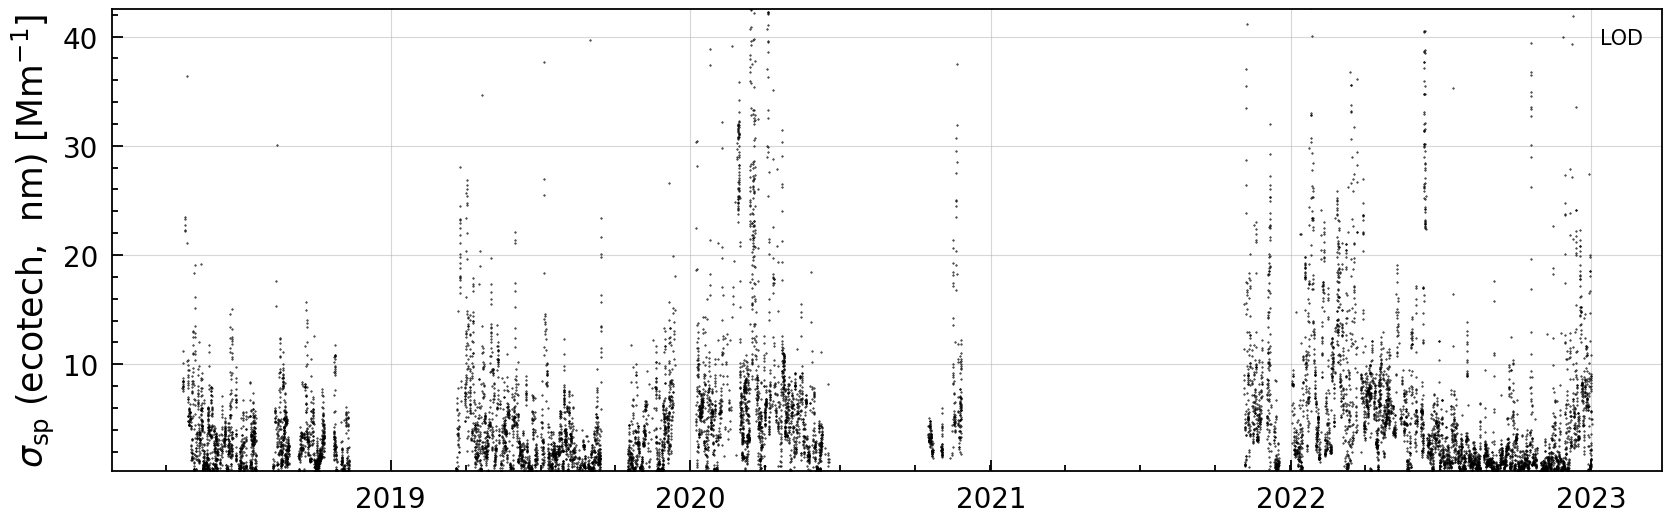

In [25]:
fig = basic_timeseries_plot(df_LOD_ecotech, var='scat525',instrument='ecotech', legendlabel='LOD')

18.66897265000008 0.19107705


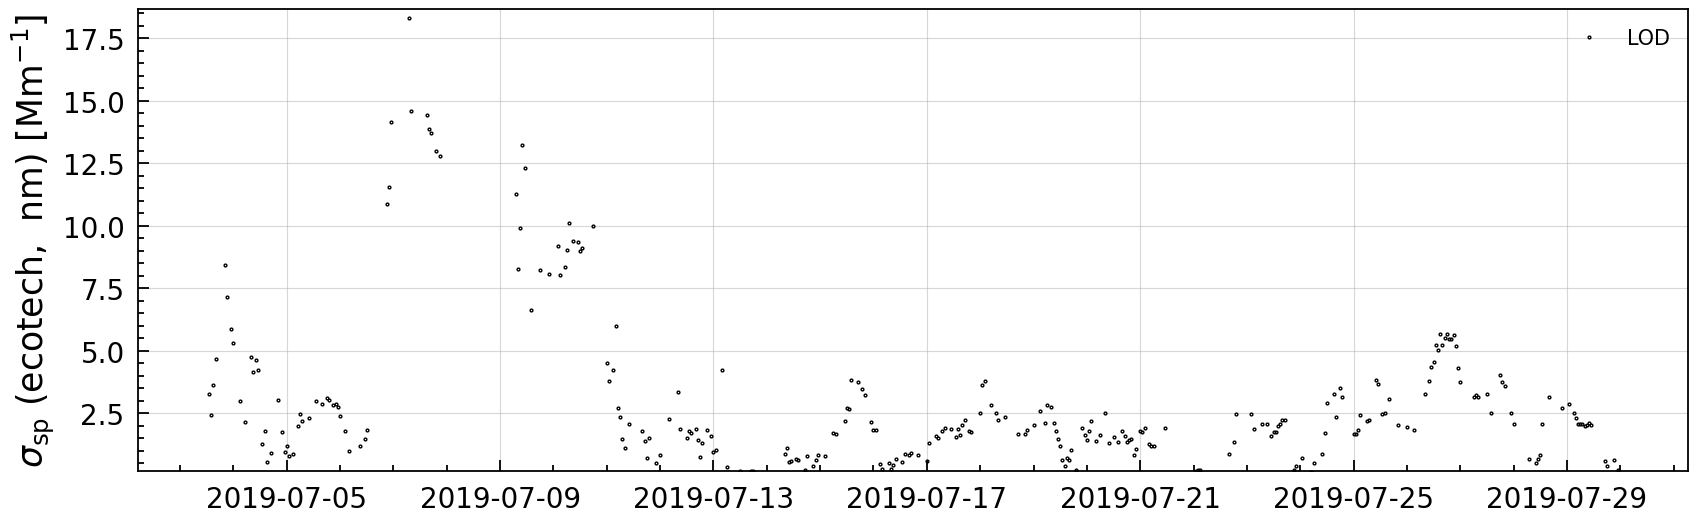

In [26]:
df_LOD_ecotech_july = df_LOD_ecotech['2019-07-01':'2019-07-29'].copy()
fig = basic_timeseries_plot(df_LOD_ecotech_july, var='scat525',instrument='ecotech', legendlabel='LOD', ms=2)

In [27]:
def select_columns(df, col_list):
    df = df[col_list]
    return df

# Compare: Merge TSI and Ecotech: 

In [28]:
df_merged_noLOD_ecotech_TSI = pd.merge(df_noLOD_TSI, df_noLOD_ecotech, left_index=True, right_index=True)

19.014635919999993 0.02538955000000021
22.398594119999995 -1.2695992199999997


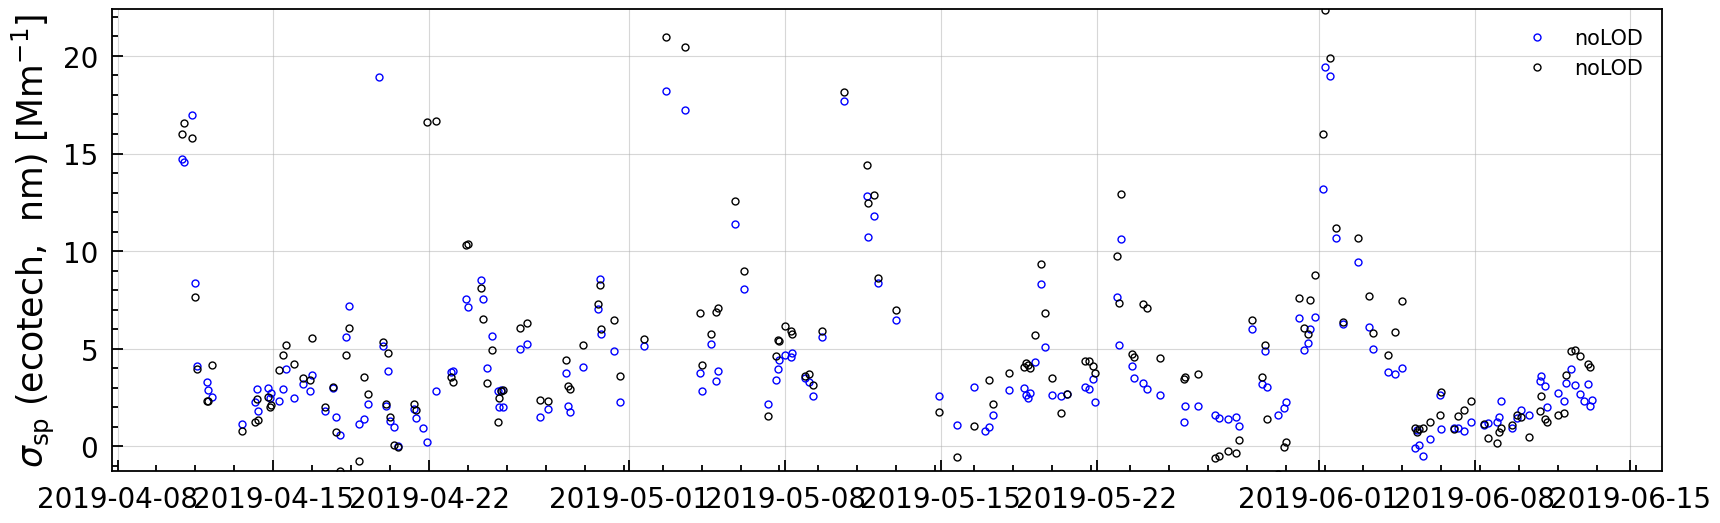

In [29]:
fig, ax = plt.subplots(figsize=(20,6))
basic_timeseries_plot(df_merged_noLOD_ecotech_TSI, var='scat450_x',instrument='TSI', legendlabel='noLOD', ms=5, mec='b', ax=ax)
basic_timeseries_plot(df_merged_noLOD_ecotech_TSI, var='scat450_y',instrument='ecotech', legendlabel='noLOD', ms=5, ax=ax)
plt.show()

19.014635919999993 0.6419911700000005
22.415107019999997 0.2283704600000001


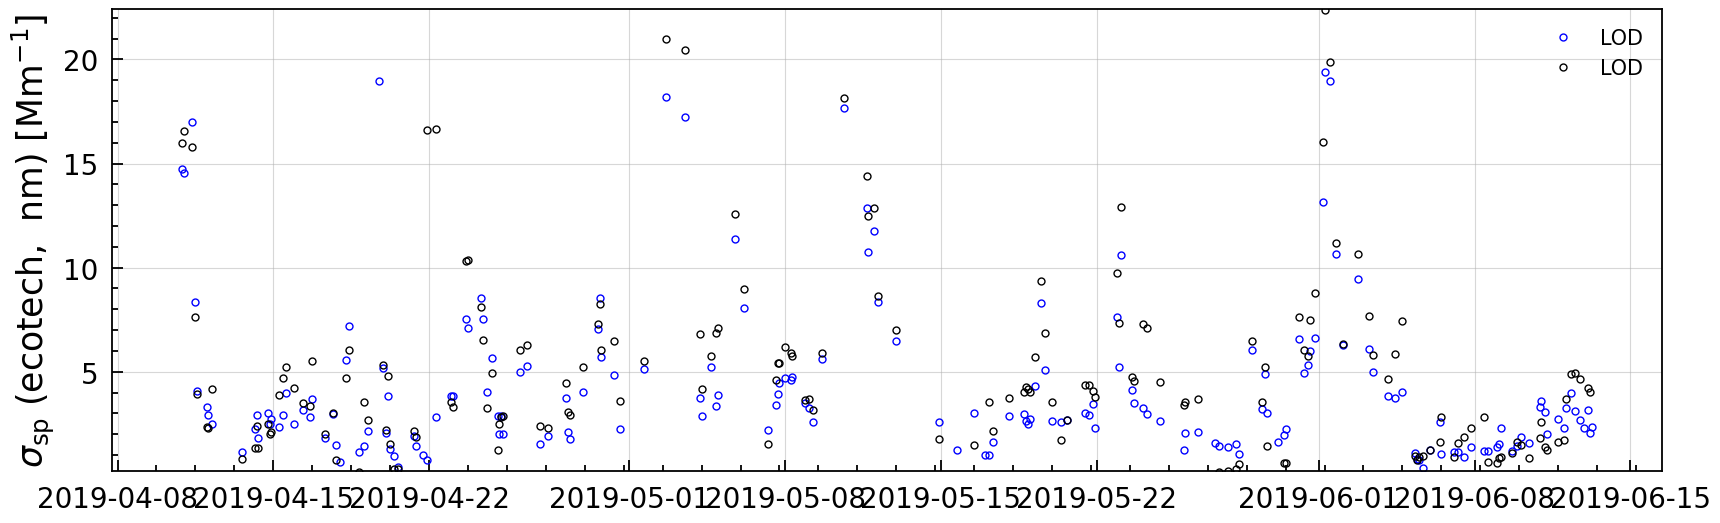

In [30]:
fig, ax = plt.subplots(figsize=(20,6))

df_merged_LOD_ecotech_TSI = pd.merge(df_LOD_TSI, df_LOD_ecotech, left_index=True, right_index=True)

basic_timeseries_plot(df_merged_LOD_ecotech_TSI, var='scat450_x',instrument='TSI', legendlabel='LOD', ms=5, mec='b', ax=ax)
basic_timeseries_plot(df_merged_LOD_ecotech_TSI, var='scat450_y',instrument='ecotech', legendlabel='LOD', ms=5, ax=ax)
plt.show()

In [31]:
def produce_ols_plot(df_merged, var, min_value=None, max_value=None, ax=None):
    print(var)
    ax.plot(df_merged[var+'_x'], df_merged[var+'_y'], 'o', mfc='None', mec='k')
    
    df_merged.loc[df_merged[str(var)+'_x'] > max_value, str(var+'_x')] = np.nan
    df_merged.loc[df_merged[str(var+'_x')] < min_value, str(var+'_x')] = np.nan
    
    df_merged.loc[df_merged[str(var)+'_y'] > max_value, str(var+'_y')] = np.nan
    df_merged.loc[df_merged[str(var+'_y')] < min_value, str(var+'_y')] = np.nan
    df_merged = df_merged[~df_merged.isin([np.nan, np.inf, -np.inf]).any(1)] #remove any infs or np.nan

    
    try:
        if max_value is None:
            max_value = max(np.percentile(df_merged[var+'_x'], 99.9), np.percentile(df_merged[var+'_y'], 99.9))
        if min_value is None:
            min_value = min(df_merged[var+'_x'].min(), df_merged[var+'_y'].min())
    except:
        max_value = 30
        min_value = 0
    
    regr = linear_model.LinearRegression(fit_intercept=True)

    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)

    Instrument1 = np.array(df_merged[var+'_x'].values)
    Instrument2 = np.array(df_merged[var+'_y'].values)

    Instrument1 = Instrument1.reshape(-1, 1)
    Instrument2 = Instrument2.reshape(-1, 1)

    regr.fit(Instrument1, Instrument2)
    y_pred = regr.predict(Instrument1)

    R2 =  "{:.2f}".format(float(regr.score(Instrument1,Instrument2)))
    intercept = "{:.2f}".format(float(regr.intercept_))
    coef = "{:.2f}".format(float(regr.coef_[0]))    
    cf =  "{:.2f}".format(float(1/(regr.coef_[0])))  

    ax.plot(np.arange(0, max_value, 0.1), np.arange(0, max_value, 0.1), ls=':', c='k')
    ax.plot(Instrument1, y_pred, color='blue', linewidth=3, 
            label='Fitted Line: \n'+str(var+'ecotech')+'  = '+str(coef)+str(var+'TSI')+' \n +'+str(intercept)+
                '\nR$^{2}$ = '+str(R2)+'\nCF = '+str(cf))

    ax.minorticks_on()
    ax.tick_params(labelsize=15)
    ax.grid(True)
    ax.legend(frameon=False, fontsize=12)
    
    if var == 'p_int':
        ax.set_ylim(min_value, max_value)
        ax.set_xlim(min_value, max_value)
    if var == 'T_int':
        ax.set_ylim(min_value, max_value)
        ax.set_xlim(min_value, max_value)
    if var == 'scat700':
        ax.set_ylim(min_value, 30)
        ax.set_xlim(min_value, 30)        
    if var in ['scat450', 'scat550', 'bscat450', 'bscat550',
             'bscat700','scat525', 'bscat525', 'scat635', 'bscat635']:
        ax.set_ylim(min_value, max_value)
        ax.set_xlim(min_value, max_value)
    thickax(ax)
    
    ax.minorticks_on()        
    ax.tick_params(direction='in', length=6, width=1.3, pad=10, bottom=True, top=True, left=True, right=True, color='k',
                   labelsize=15, axis='both')
    ax.tick_params(which='minor', direction='in', length=3, color='k', width=1.3, bottom=True, top=True, left=True, right=True,
                   labelsize=15, axis='both')
    ax.set_xlim(min_value, max_value)
    ax.set_ylim(min_value, max_value)
    ax.set_yticks(np.arange(int(min_value), int(max_value)+10, 10))
    ax.set_xticks(np.arange(int(min_value), int(max_value)+10, 10))
    
    return ax

In [32]:
def produce_subplots_regression(df_merged, variables, savename = 'Ecotech_TSI', size_multiple=8,
                               delete_axes=None, xlabel_pad=0.04, min_value=None, nrows = 3,
                               max_value=None):
    number_of_variables = len(variables)    
    ncols = int(round(number_of_variables/nrows))
    rows = np.arange(0, nrows, 1)
    cols = np.arange(0, ncols, 1)
    
    n_axes = list(itertools.product(rows, cols))

    fig, ax = plt.subplots(nrows, ncols, figsize=(size_multiple*(ncols)*0.65, ncols*size_multiple))

    for i, var_n in zip(range(len(n_axes)), range(number_of_variables)):
        row = int(n_axes[i][0])
        col = int(n_axes[i][1])
        produce_ols_plot(df_merged, var=variables[var_n], min_value=min_value, 
                         max_value=max_value, ax=ax[row][col]) 
                
    if delete_axes is not None:
        row_delete = delete_axes[0]
        col_delete = delete_axes[-1]
        fig.delaxes(ax[row_delete][col_delete])

    fig.text(0.5, xlabel_pad, 'TSI [Mm$^{-1}$]', ha='center', fontsize=30)
    fig.text(0.04, 0.5, 'Ecotech [Mm$^{-1}$]', va='center', rotation='vertical', fontsize=30)

    plt.show()
    return fig

In [33]:
def calculate_correction_factor(df_merged, var, min_value=None, max_value=None):
    df_merged.loc[df_merged[str(var)+'_x'] > max_value, str(var+'_x')] = np.nan
    df_merged.loc[df_merged[str(var+'_x')] < min_value, str(var+'_x')] = np.nan    
    df_merged.loc[df_merged[str(var)+'_y'] > max_value, str(var+'_y')] = np.nan
    df_merged.loc[df_merged[str(var+'_y')] < min_value, str(var+'_y')] = np.nan
    
    df_merged = df_merged[~df_merged.isin([np.nan, np.inf, -np.inf]).any(1)] #remove any infs or np.nan
    
    regr = linear_model.LinearRegression(fit_intercept=True)
    Instrument1 = np.array(df_merged[var+'_x'].values)
    Instrument2 = np.array(df_merged[var+'_y'].values)
    Instrument1 = Instrument1.reshape(-1, 1)
    Instrument2 = Instrument2.reshape(-1, 1)
    regr.fit(Instrument1, Instrument2)
    y_pred = regr.predict(Instrument1)

    R2 =  "{:.2f}".format(float(regr.score(Instrument1,Instrument2)))
    intercept = "{:.2f}".format(float(regr.intercept_))
    coef = "{:.2f}".format(float(regr.coef_[0]))    
    cf =  "{:.2f}".format(float(1/(regr.coef_[0])))  
    return R2, intercept, coef, cf

In [34]:
def select_times(df, start, end):
    df = df[((pd.to_datetime(start)) < df.index) & (df.index < (pd.to_datetime(end)))]
    return df

In [35]:
print(df_LOD_TSI[['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700']].head(2))
print(df_LOD_ecotech[['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700']].head(2))

                     scat450   scat525   scat530   scat550   scat635  scat637  \
date                                                                            
1999-05-17 18:00:00      NaN       NaN       NaN  0.463493       NaN      NaN   
1999-05-17 19:00:00  4.50722  3.208207  3.141837  2.895378  1.738108  1.72305   

                      scat700  
date                           
1999-05-17 18:00:00  1.224965  
1999-05-17 19:00:00  1.327292  
                      scat450   scat525   scat530   scat550   scat635  \
datetime                                                                
2018-04-22 14:00:00  8.831231  7.797530  7.738070  7.510026  7.296213   
2018-04-22 16:00:00  9.232571  7.945371  7.872352  7.593385  7.241873   

                      scat637   scat700  
datetime                                 
2018-04-22 14:00:00  7.283503  6.912433  
2018-04-22 16:00:00  7.225831  6.760883  


## LOD: ecotech is slightly less than TSI: 

In [ ]:
variables=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700']
df_merged_LOD = pd.merge(df_LOD_TSI[variables], df_LOD_ecotech[variables], left_index=True, right_index=True)

fig = produce_subplots_regression(df_merged_LOD, 
                           variables=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700'],
                           min_value=0, max_value=30, xlabel_pad=0.06, delete_axes=[-1,-1])

## noLOD: 

scat450
scat525
scat530
scat550
scat635
scat637


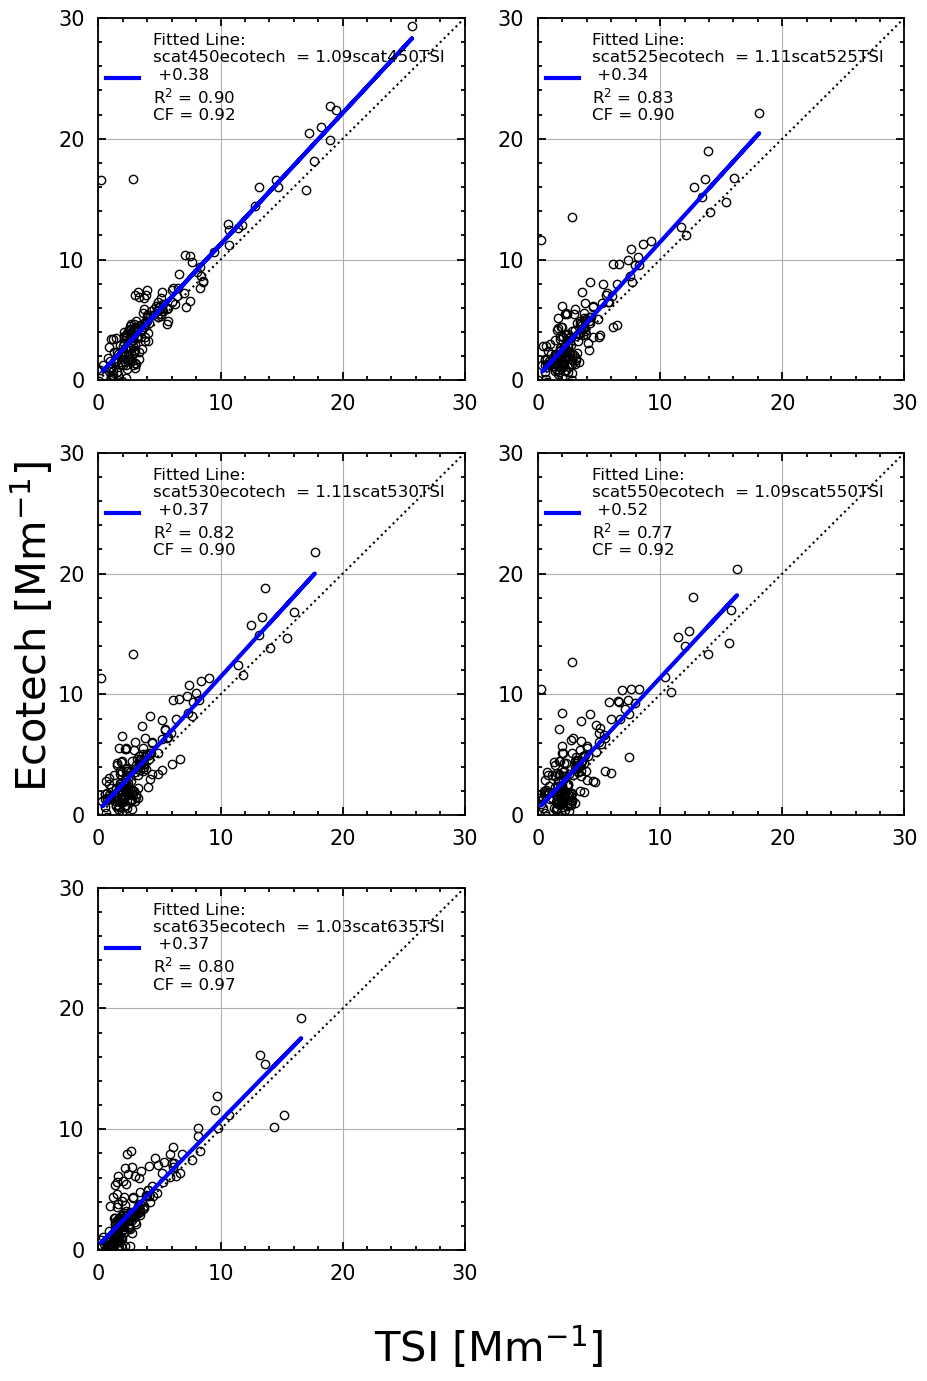

In [38]:
variables=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700']
df_merged_noLOD = pd.merge(df_noLOD_TSI[variables], df_noLOD_ecotech[variables], left_index=True, right_index=True)

fig = produce_subplots_regression(df_merged_noLOD, 
                                  variables=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700'],
                                  min_value=0, max_value=30, delete_axes=[-1,-1])

In [39]:
print(df_merged_noLOD.index[0])
print(df_merged_noLOD.index[-1])

2019-04-10 22:00:00
2019-06-13 06:00:00


# Merge, correct and concat: 

In [40]:
def correct_dfs(df_TSI, df_ecotech, cols=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700'],
               perform_correction=False, min_value=None, max_value=None):
    print("lenght of TSI: "+str(len(df_TSI)))
    print("lenght of ecotech: "+str(len(df_ecotech)))
    
    df_TSI = df_TSI.copy(); df_ecotech = df_ecotech.copy() #copy dataframes
    dict_var_to_CF = {} #dictionary for correction factor
    
    df_merged = pd.merge(df_LOD_TSI[cols], df_LOD_ecotech[cols], left_index=True, right_index=True) #merge
    
    if perform_correction == True:
        print("Apply correction factors to ecotech: ")
        for var in cols:
            print(var)
            R2, intercept, coef, cf = calculate_correction_factor(df_merged, var, min_value=min_value,
                                                                  max_value=max_value) #perform comparsion
            print("R2: "+str(R2))
            print("Intercept: "+str(intercept))
            print("Coef: "+str(coef))
            print("Correction factor: "+str(cf))
            dict_var_to_CF[var] = cf
            df_ecotech[var] = df_ecotech[var]*float(cf) #apply correction factor
    
    df_TSI = sort_index(df_TSI)
    df_ecotech = sort_index(df_ecotech)

    frames = [df_TSI, df_ecotech] 
    df = pd.concat(frames)
    
    print("lenght of df: "+str(len(df)))
    
    fu.find_number_of_duplicate_indexs(df)
    df_first, df_last = fu.remove_duplicates(df)
    df = df_first.copy()    
    return df

## lod

In [41]:
df_LOD = correct_dfs(df_LOD_TSI, df_LOD_ecotech, 
                     cols=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700'],
                     perform_correction=True, min_value=0, max_value=30)

lenght of TSI: 98530
lenght of ecotech: 11992
Apply correction factors to ecotech: 
scat450
R2: 0.84
Intercept: 0.53
Coef: 1.07
Correction factor: 0.93
scat525
R2: 0.79
Intercept: 0.32
Coef: 1.11
Correction factor: 0.90
scat530
R2: 0.79
Intercept: 0.34
Coef: 1.11
Correction factor: 0.90
scat550
R2: 0.74
Intercept: 0.47
Coef: 1.09
Correction factor: 0.92
scat635
R2: 0.54
Intercept: 0.78
Coef: 0.98
Correction factor: 1.03
scat637
R2: 0.53
Intercept: 0.79
Coef: 0.97
Correction factor: 1.03
scat700
R2: 0.33
Intercept: 1.19
Coef: 0.90
Correction factor: 1.11
lenght of df: 110522
Duplicate Rows except first occurrence based on all columns are :
190
Length before: 110522
Duplicate Rows except first occurrence based on all columns are :
190
DatetimeIndex(['2019-04-10 22:00:00', '2019-04-11 00:00:00',
               '2019-04-11 08:00:00', '2019-04-11 12:00:00',
               '2019-04-11 14:00:00', '2019-04-12 00:00:00',
               '2019-04-12 02:00:00', '2019-04-12 06:00:00',
             

## noLOD: 

In [42]:
df_noLOD = correct_dfs(df_noLOD_TSI, df_noLOD_ecotech, 
                     cols=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700'],
                     min_value=0, max_value=30, perform_correction=True)

lenght of TSI: 90644
lenght of ecotech: 11992
Apply correction factors to ecotech: 
scat450
R2: 0.84
Intercept: 0.53
Coef: 1.07
Correction factor: 0.93
scat525
R2: 0.79
Intercept: 0.32
Coef: 1.11
Correction factor: 0.90
scat530
R2: 0.79
Intercept: 0.34
Coef: 1.11
Correction factor: 0.90
scat550
R2: 0.74
Intercept: 0.47
Coef: 1.09
Correction factor: 0.92
scat635
R2: 0.54
Intercept: 0.78
Coef: 0.98
Correction factor: 1.03
scat637
R2: 0.53
Intercept: 0.79
Coef: 0.97
Correction factor: 1.03
scat700
R2: 0.33
Intercept: 1.19
Coef: 0.90
Correction factor: 1.11
lenght of df: 102636
Duplicate Rows except first occurrence based on all columns are :
190
Length before: 102636
Duplicate Rows except first occurrence based on all columns are :
190
DatetimeIndex(['2019-04-10 22:00:00', '2019-04-11 00:00:00',
               '2019-04-11 08:00:00', '2019-04-11 12:00:00',
               '2019-04-11 14:00:00', '2019-04-12 00:00:00',
               '2019-04-12 02:00:00', '2019-04-12 06:00:00',
             

# Timeseries: lod & noLOD

In [43]:
def basic_timeseries_ax(df, var, instrument='TSI', wavelength=' ', legendlabel='detection limits', startdate=None,
                        enddate=None, monthly=False, savepath=None, savename='default',c='k', 
                        ymin=None, ymax=None, ms=1, x_box=0.95, y_box=1.1, ax=None):   
    label = '$\sigma_{\mathrm{sp}}$ ('+str(instrument)+','+str(wavelength)+' nm) [Mm$^{-1}$]'
    
    qtop, qbottom = find_top_both_quantiles(df, var)

    ax.plot(df.index, df[var],'o',ms=ms, label=legendlabel, mec=c, mfc='None')
    ax.set_ylabel(label, fontsize=25)
    ax.legend(fontsize=15, markerscale=5., frameon=False, 
              bbox_to_anchor=(x_box, y_box), borderaxespad=0)
    
    if (ymin != None) & (ymax != None):        
        ax.set_ylim(ymin, ymax)
    if (ymin == None) & (ymax == None): 
        ax.set_ylim(qbottom,qtop)
        
    ax.set_xlim(pd.to_datetime(startdate), pd.to_datetime(enddate))
    
    thickax(ax)    
    ax.minorticks_on()
    ax.tick_params(axis='both', which='major', labelsize=20, direction='in') #, rotation=45)
    ax.tick_params(axis='both', which='minor', labelsize=20, direction='in') #, rotation=45)
    ax.grid(True, alpha=0.5)     

    if monthly == True:
        df_resampled = df[var].resample('M').median()
        ax.plot(df_resampled.index, df_resampled.values, 'o-', c='r')

    return ax

# LOD: 

In [44]:
df_LOD = sort_index(df_LOD)

24.668361339600004 0.32014256


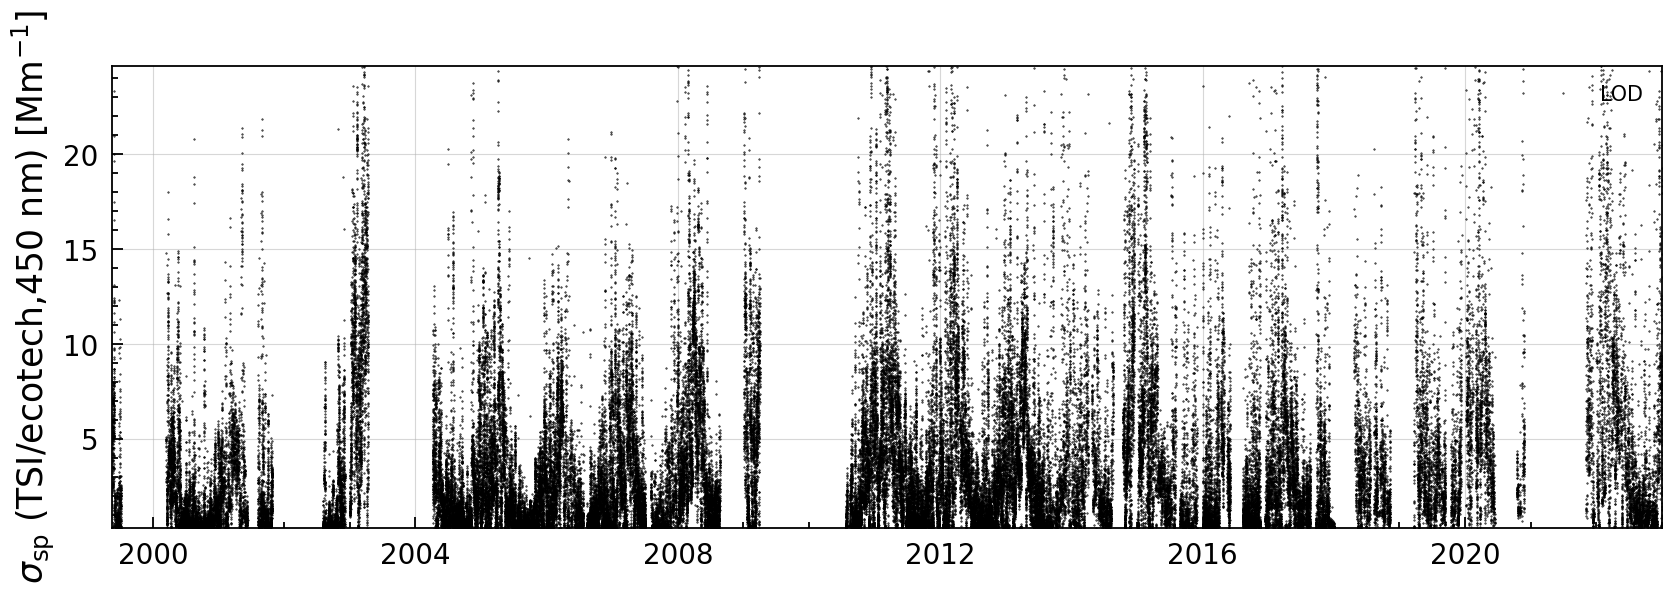

In [45]:
fig = basic_timeseries_plot(df_LOD, var='scat450',instrument='TSI/ecotech', wavelength='450', legendlabel='LOD', 
                      startdate=df_LOD.index[0], enddate=df_LOD.index[-1])

In [46]:
cols = df_LOD.columns
count_cols = [x for x in cols if 'count' in x]
print(count_cols)

def exclude_cols(df, exclude_col_list):
    return df[df.columns[~df.columns.isin(exclude_col_list)]]

['scat450_count', 'scat550_count', 'scat700_count', 'bscat450_count', 'bscat550_count', 'bscat700_count', 'scat525_count', 'scat635_count', 'bscat525_count', 'bscat635_count']


In [47]:
df_LOD = exclude_cols(df_LOD, count_cols)
del df_LOD['Flag']

24.668361339600004 0.32014256


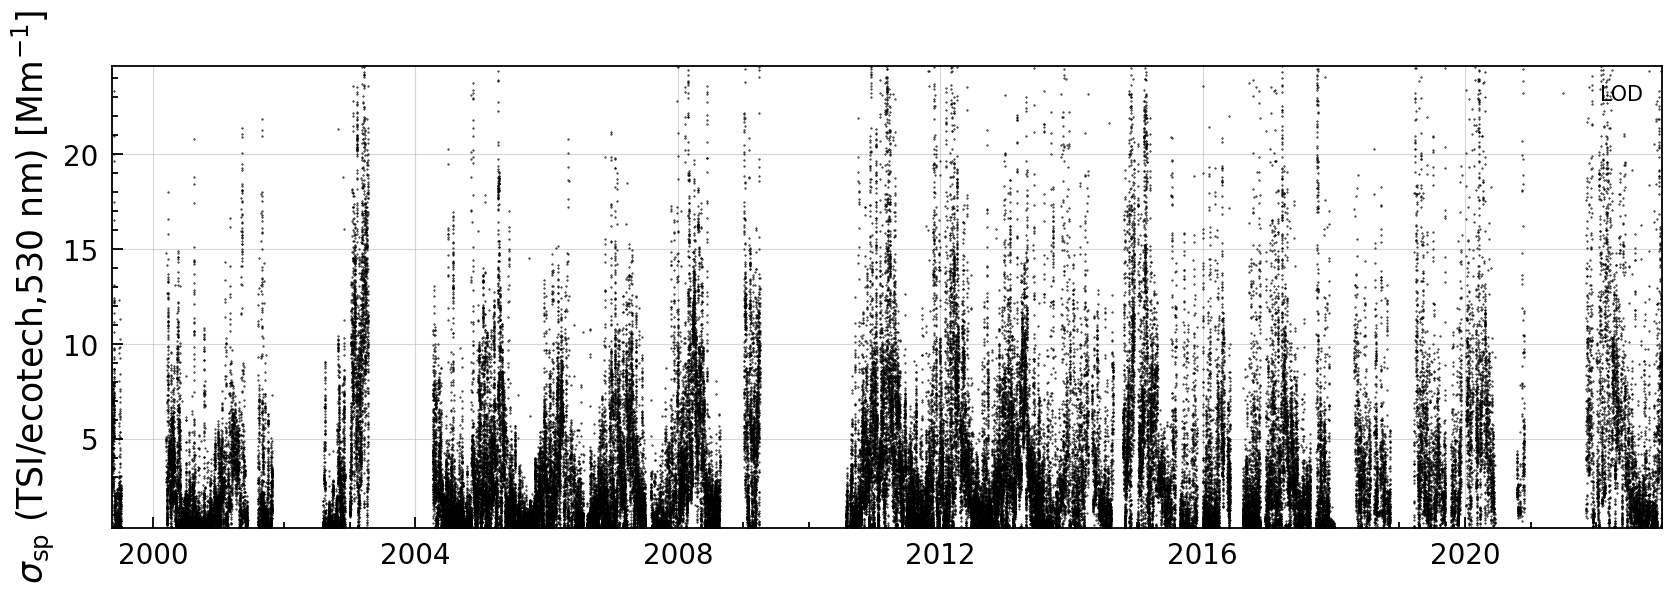

In [48]:
fig = basic_timeseries_plot(df_LOD, var='scat450',instrument='TSI/ecotech', wavelength='530', legendlabel='LOD', 
                      startdate=df_LOD.index[0], enddate=df_LOD.index[-1], percentile_value=0.99)

4.671168190000014 -5.104915039999998


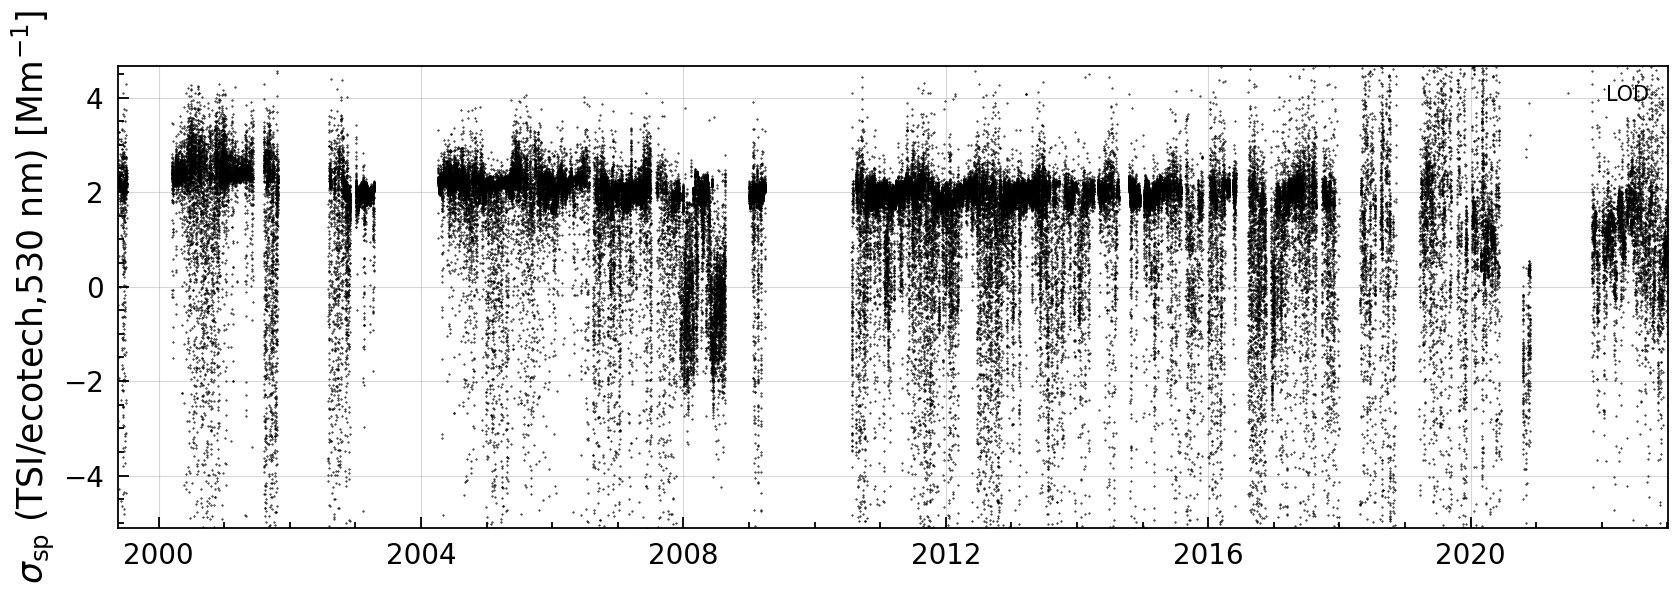

In [49]:
fig = basic_timeseries_plot(df_LOD, var='AE_450',instrument='TSI/ecotech', wavelength='530', legendlabel='LOD', 
                      startdate=df_LOD.index[0], enddate=df_LOD.index[-1], percentile_value=0.99)

In [50]:
df_LOD_cleaned = df_LOD[df_LOD.std_cleaned_data == 1]

23.458524339999997 0.32701146000000003


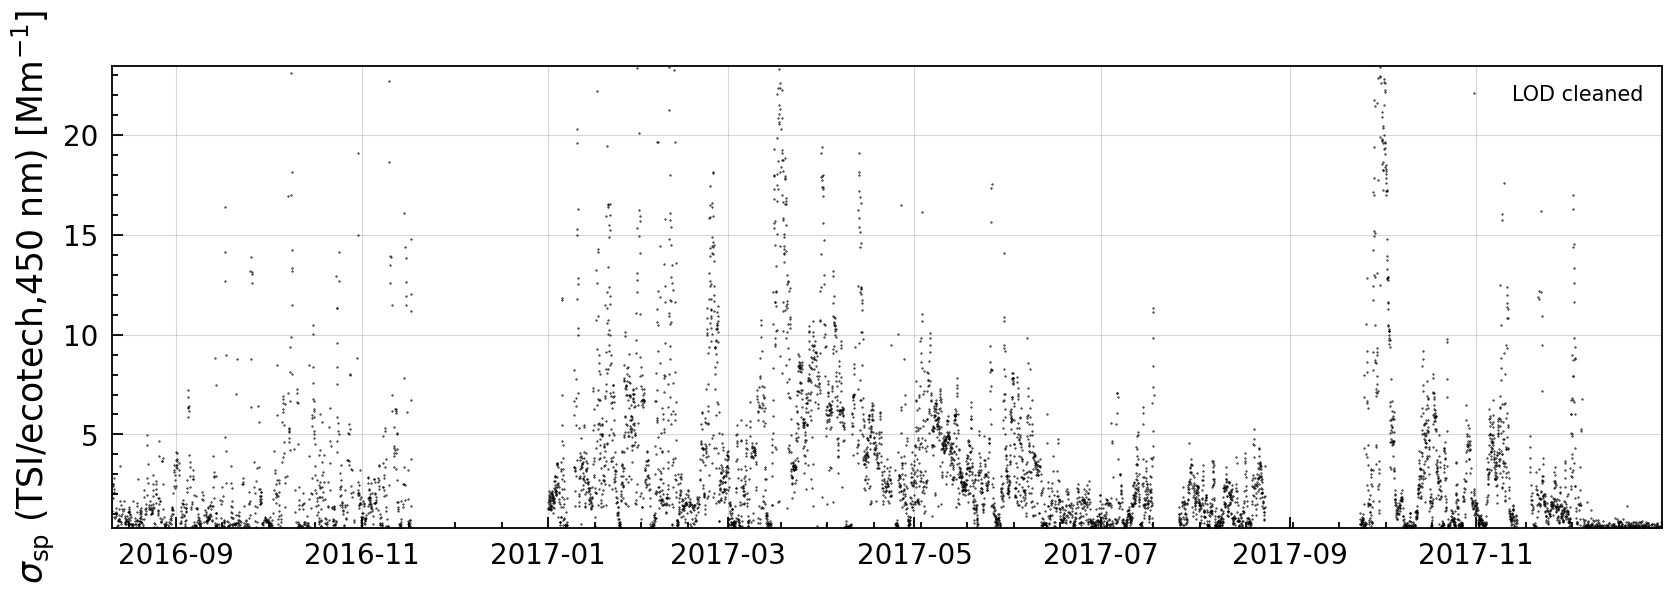

In [51]:
fig = basic_timeseries_plot(df_LOD_cleaned, var='scat450',instrument='TSI/ecotech', wavelength='450', 
                            legendlabel='LOD cleaned', 
                            startdate=df_LOD_cleaned.index[0], enddate=df_LOD_cleaned.index[-1], 
                            percentile_value=0.99)

23.458524339999997 0.32701146000000003


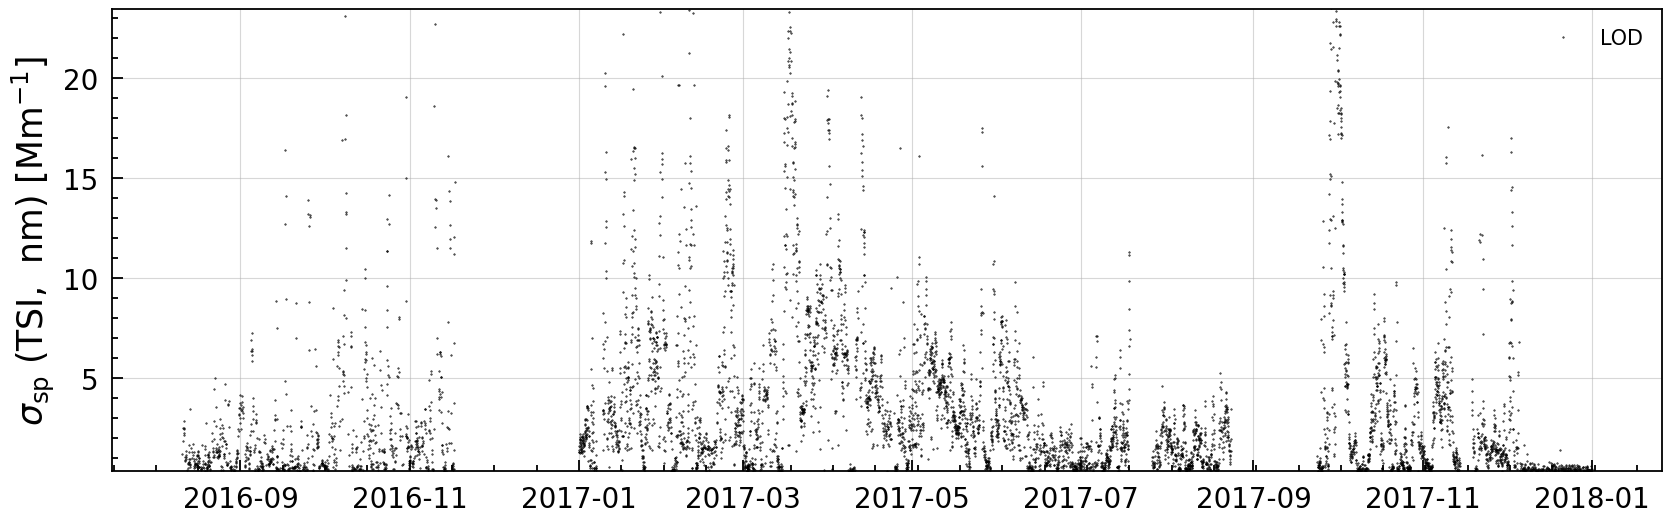

21.630889349999872 0.31995689


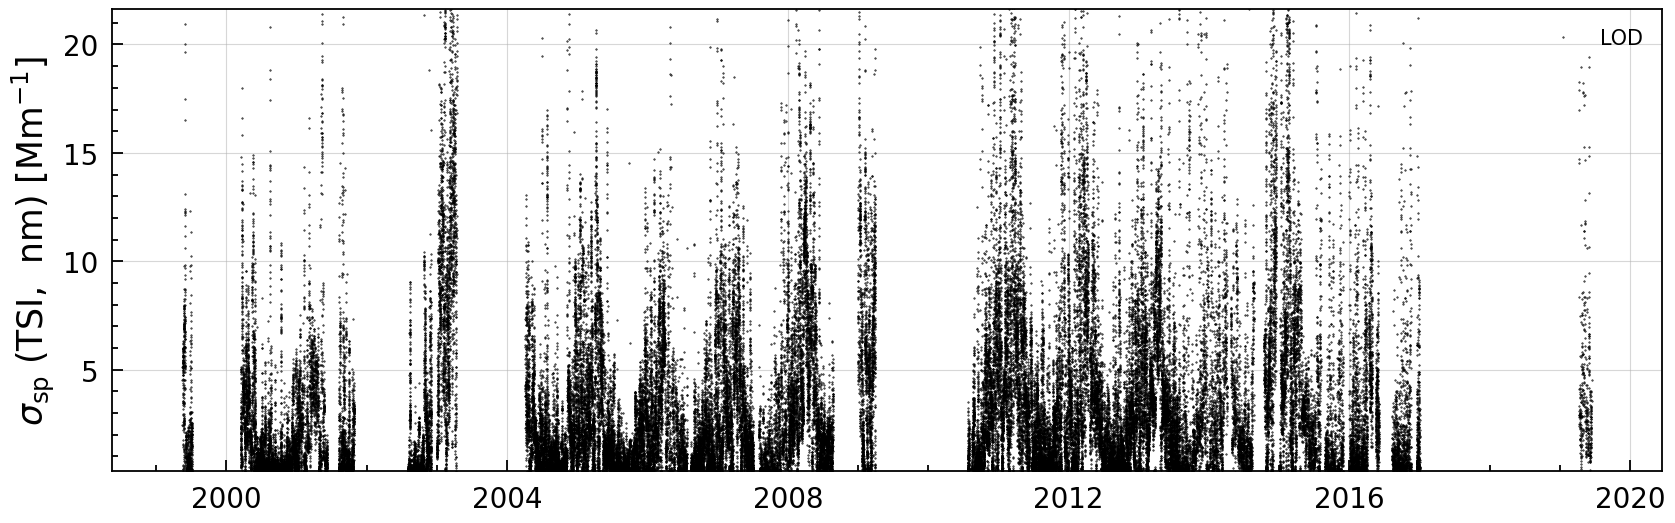

In [52]:
df_LOD_cleaned = df_LOD[df_LOD.std_cleaned_data == 1]
df_LOD_normal = df_LOD[df_LOD.std_cleaned_data == 0]

fig = basic_timeseries_plot(df_LOD_cleaned, var='scat450', instrument='TSI',
                            legendlabel='LOD')
fig = basic_timeseries_plot(df_LOD_normal, var='scat450', instrument='TSI',
                            legendlabel='LOD')

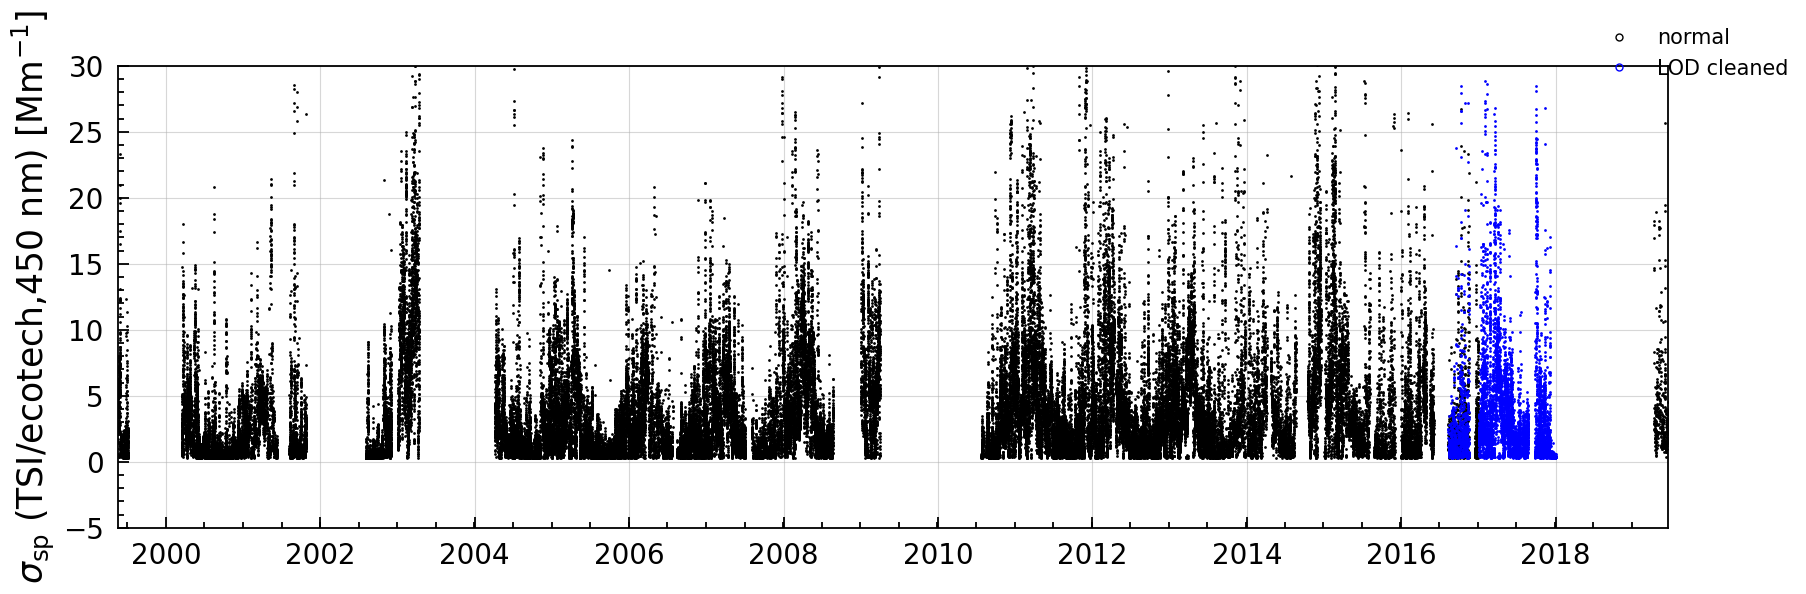

In [53]:
fig, ax = plt.subplots(figsize=(20,6))

basic_timeseries_ax(df_LOD_normal, var='scat450',instrument='TSI/ecotech', wavelength='450', legendlabel='normal', 
                      startdate=df_LOD_normal.index[0], enddate=df_LOD_normal.index[-1], c='k', ymin=-5, ymax=30,  ax=ax)
basic_timeseries_ax(df_LOD_cleaned, var='scat450',instrument='TSI/ecotech', wavelength='450', legendlabel='LOD cleaned', 
                      startdate=df_LOD_normal.index[0], enddate=df_LOD_normal.index[-1], c='b', ymin=-5, ymax=30, ax=ax)

plt.show()

## nolod: 

In [54]:
df_noLOD = sort_index(df_noLOD)

24.51667980000004 -0.5895864


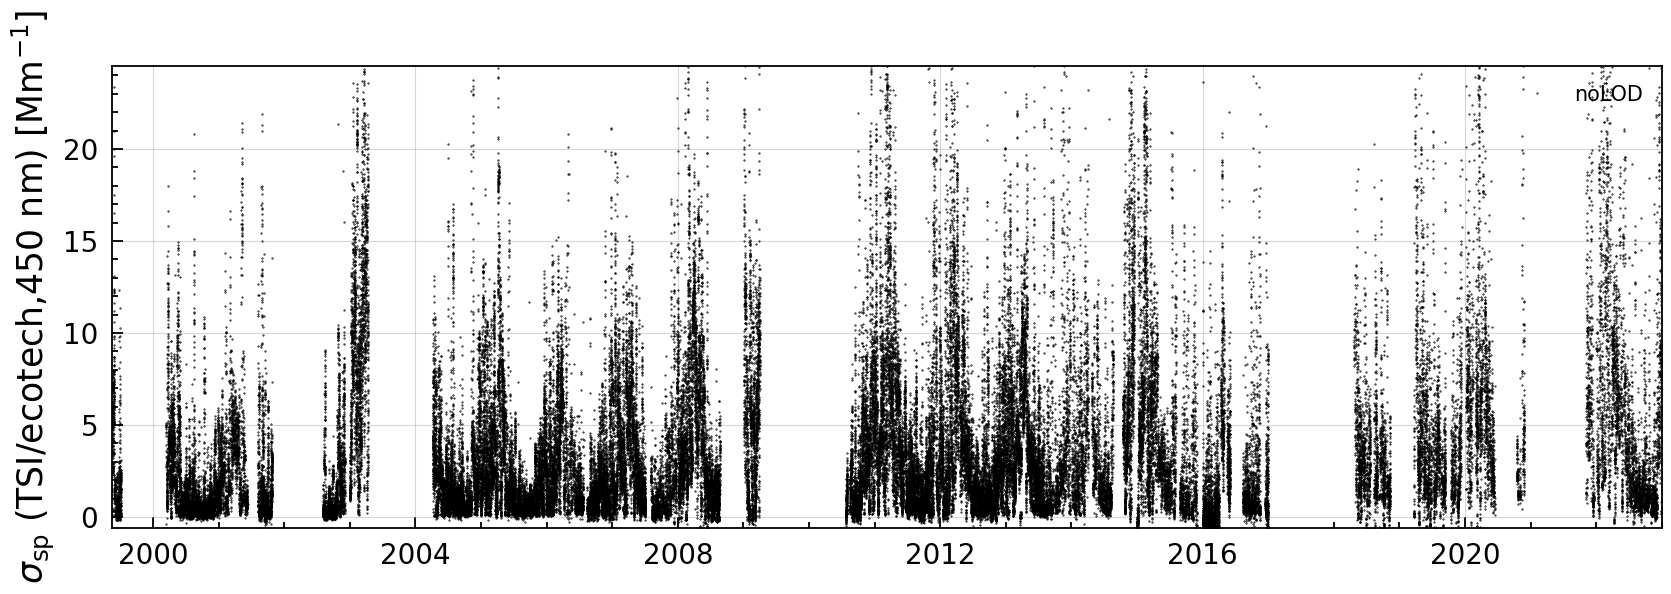

In [55]:
fig = basic_timeseries_plot(df_noLOD, var='scat450',instrument='TSI/ecotech', wavelength='450', legendlabel='noLOD', 
                      startdate=df_noLOD.index[0], enddate=df_noLOD.index[-1])

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))

df_noLOD_july = df_noLOD['2019-07-01':'2019-07-29'].copy()

basic_timeseries_ax(df_noLOD_july, var='scat530',instrument='TSI/ecotech', wavelength='530', 
                    legendlabel='no LOD', startdate=df_noLOD_july.index[0], ms=2,
                    enddate=df_noLOD_july.index[-1], ax=ax)
plt.show()

In [57]:
len(df_noLOD_july)

315

# Bring in with DMPS:

In [58]:
df_2000_2005_Mie = pd.read_csv(loadpath+"df_2000_2005_Mie.dat", index_col=0, parse_dates=True)
df_2006_2009_Mie = pd.read_csv(loadpath+"df_2006_2009_Mie.dat", index_col=0, parse_dates=True)
df_2010_2020_Mie = pd.read_csv(loadpath+"df_2010_2020_Mie.dat", index_col=0, parse_dates=True)

df_2000_2020_Mie = pd.concat([df_2000_2005_Mie, df_2006_2009_Mie, df_2010_2020_Mie])
df_2000_2020_Mie = df_2000_2020_Mie.replace(0, np.nan)

df_2000_2020_Mie['Mie'] = 1

df_2000_2020_Mie = df_2000_2020_Mie.sort_index()

In [59]:
def create_timeseries(df, var, df_Mie, Mie_var='scat550', df_label='obs',
                              min_index=None, max_index=None, set_max_value=10, 
                              name='PSAP', plot_raw=True, ms=5, Miemax=40, sameax=True):  
    
    if sameax == False:
        fig, (ax1,ax2) = plt.subplots(2,1, figsize=(15,5), sharex=True)
        fig.subplots_adjust(hspace=.5)
    if sameax == True:
        fig, ax1 = plt.subplots(1,1, figsize=(15,5), sharex=True)
        ax2 = ax1.twinx()
        
    ax1.set_title(str(name), loc='left')
    ax1.plot(df.index, df[var], 'o', mfc='None', ms=ms, label=df_label)
               
    ax1.set_ylim(0, set_max_value)
    ax1.legend(frameon=False, loc=1) 

    ax2.plot(df_Mie.index, df_Mie[Mie_var], 'D', mec='k', mfc='k', ms=ms, alpha=0.4,
             label='Mie: '+str(Mie_var)) 
    ax2.set_ylim(0, Miemax)

    if min_index is None:
        min_index = df.index[0] - pd.DateOffset(days=5)    
    if max_index is None:
        max_index = df.index[-1] + pd.DateOffset(days=5)
    else:
        min_index = pd.to_datetime(min_index)
        max_index = pd.to_datetime(max_index)
    
    ax2.legend(frameon=False, loc=2) 
    ax2.set_title(label='',  loc='left', fontsize=10)   

    for ax in [ax1, ax2]:       
        ax.set_xlim(min_index, max_index)
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')  
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.tick_params(direction='out', length=6, width=1.3, pad=10, bottom=True, top=False, left=True, right=False, color='k')
        ax.tick_params(which='minor', direction='out', length=3, color='k', width=1.3, bottom=True, top=False, left=True, right=False)
        ax.grid(True, alpha=0.5)
    plt.show()
    return fig

## MAKE plots of both: 

### LOD: 

In [ ]:
for year in np.arange(2011, 2020, 1):
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:    
        try:
            create_timeseries(df_LOD, var='scat550', df_Mie=df_2000_2020_Mie, Mie_var='scat550',
                          df_label='obs: scat550', min_index=str(year)+'-'+str(month)+'-27 19:00:00', 
                          max_index=str(year)+'-'+str(month+1)+'-27 19:00:00', set_max_value=40, 
                          name='Obs', plot_raw=True, ms=5, Miemax=40)
        except:
            plt.clf()
            pass

### nolod:

In [ ]:
for year in np.arange(2011, 2020, 1):
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:    
        try:
            create_timeseries(df_noLOD, var='scat550', df_Mie=df_2000_2020_Mie, Mie_var='scat550',
                          df_label='obs: scat550', min_index=str(year)+'-'+str(month)+'-27 19:00:00', 
                          max_index=str(year)+'-'+str(month+1)+'-27 19:00:00', set_max_value=40, 
                          name='Obs', plot_raw=True, ms=5, Miemax=40)
        except:
            plt.clf()
            pass

## Day offset

In [62]:
df_LOD = day_offset(df_LOD, number_of_days=1, split_time='2018-01-01 00:00:00', add=False, substract=True)
df_noLOD = day_offset(df_noLOD, number_of_days=1, split_time='2018-01-01 00:00:00', add=False, substract=True)

110332
110332
Day substracted: 1 from 2018-01-01 00:00:00
102446
102446
Day substracted: 1 from 2018-01-01 00:00:00


In [ ]:
for year in np.arange(2011, 2020, 1):
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:    
        try:
            create_timeseries(df_LOD, var='scat550', df_Mie=df_2000_2020_Mie, Mie_var='scat550',
                          df_label='obs: scat550', min_index=str(year)+'-'+str(month)+'-27 19:00:00', 
                          max_index=str(year)+'-'+str(month+1)+'-27 19:00:00', set_max_value=40, 
                          name='Obs', plot_raw=True, ms=5, Miemax=40)
        except:
            plt.clf()
            pass

In [ ]:
for year in np.arange(2011, 2020, 1):
    for month in [1,2,3,4,5,6,7,8,9,10,11,12]:    
        try:
            create_timeseries(df_noLOD, var='scat550', df_Mie=df_2000_2020_Mie, Mie_var='scat550',
                          df_label='obs: scat550', min_index=str(year)+'-'+str(month)+'-27 19:00:00', 
                          max_index=str(year)+'-'+str(month+1)+'-27 19:00:00', set_max_value=40, 
                          name='Obs', plot_raw=True, ms=5, Miemax=40)
        except:
            plt.clf()
            pass

## Save: 

In [65]:
fu.save_df(df_noLOD, path=savepath, 
           name='df_scat_TSI_ecotech_noLOD')
fu.save_df(df_LOD, path=savepath, 
           name='df_scat_TSI_ecotech_LOD')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_scat_TSI_ecotech_noLOD.dat
Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_scat_TSI_ecotech_LOD.dat


## Merge with DMPS:

In [66]:
def merge_dfs_remove_duplicate(df_LOD, df_2000_2020_Mie):
    df_LOD = df_LOD.copy()
    df_LOD.loc[:, 'Mie'] = 0
    df_LOD = sort_index(df_LOD)
    df_2000_2020_Mie = sort_index(df_2000_2020_Mie)
    df_2000_2020_Mie.loc[:, 'Mie'] = 1
    
    fu.find_number_of_duplicate_indexs(df_LOD)
    fu.find_number_of_duplicate_indexs(df_2000_2020_Mie)
    
    frames = [df_LOD, df_2000_2020_Mie] 
    df = pd.concat(frames)

    duplicate_indexes = fu.find_number_of_duplicate_indexs(df)

    df_notdup = df.loc[~df.index.isin(duplicate_indexes)]
    df_dup = df.loc[duplicate_indexes]
    
    df_dup_not_Mie = df_dup[df_dup['Mie'] == 0]
    
    df_complete = pd.concat([df_notdup, df_dup_not_Mie])
    df_complete = df_complete.sort_index()
    return df_complete

In [67]:
df_LOD_Mie = merge_dfs_remove_duplicate(df_LOD, df_2000_2020_Mie)

Duplicate Rows except first occurrence based on all columns are :
0
Duplicate Rows except first occurrence based on all columns are :
0
Duplicate Rows except first occurrence based on all columns are :
104427


In [68]:
df_noLOD_Mie = merge_dfs_remove_duplicate(df_noLOD, df_2000_2020_Mie)

Duplicate Rows except first occurrence based on all columns are :
0
Duplicate Rows except first occurrence based on all columns are :
0
Duplicate Rows except first occurrence based on all columns are :
96541


## LOD: 

<Figure size 1500x500 with 0 Axes>

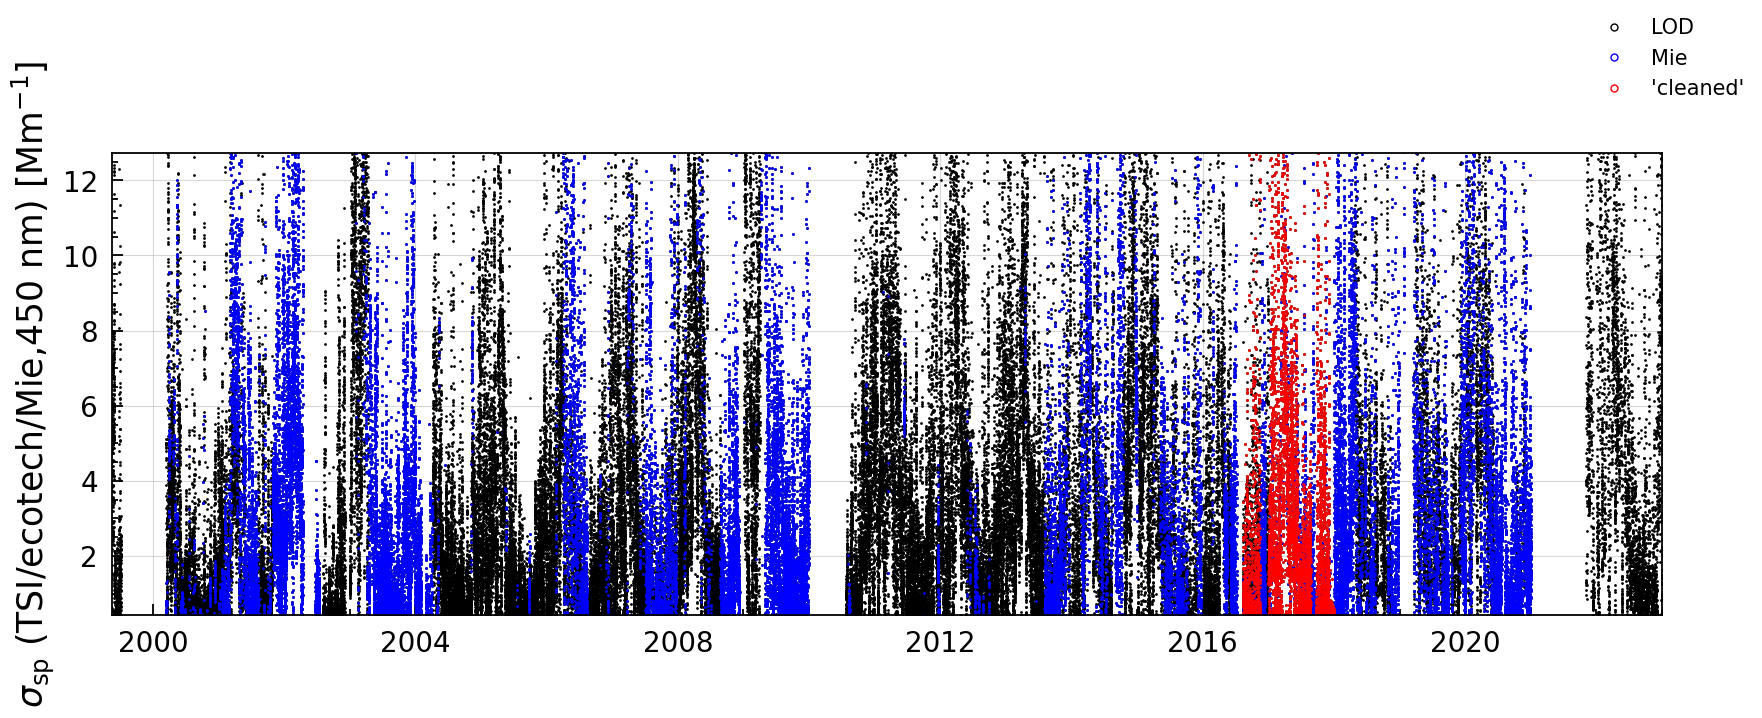

In [69]:
fig, ax = plt.subplots(figsize=(20,6))
basic_timeseries_ax(df_LOD_Mie, var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='LOD', 
                      startdate=df_LOD_Mie.index[0], enddate=df_LOD_Mie.index[-1], ax=ax)
basic_timeseries_ax(df_LOD_Mie[df_LOD_Mie.Mie == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='Mie', 
                      startdate=df_LOD_Mie.index[0], enddate=df_LOD_Mie.index[-1], c='b', ax=ax)
basic_timeseries_ax(df_LOD_Mie[df_LOD_Mie.std_cleaned_data == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', 
                      legendlabel="'cleaned'", 
                      startdate=df_LOD_Mie.index[0], enddate=df_LOD_Mie.index[-1], c='r', ax=ax)
plt.show()

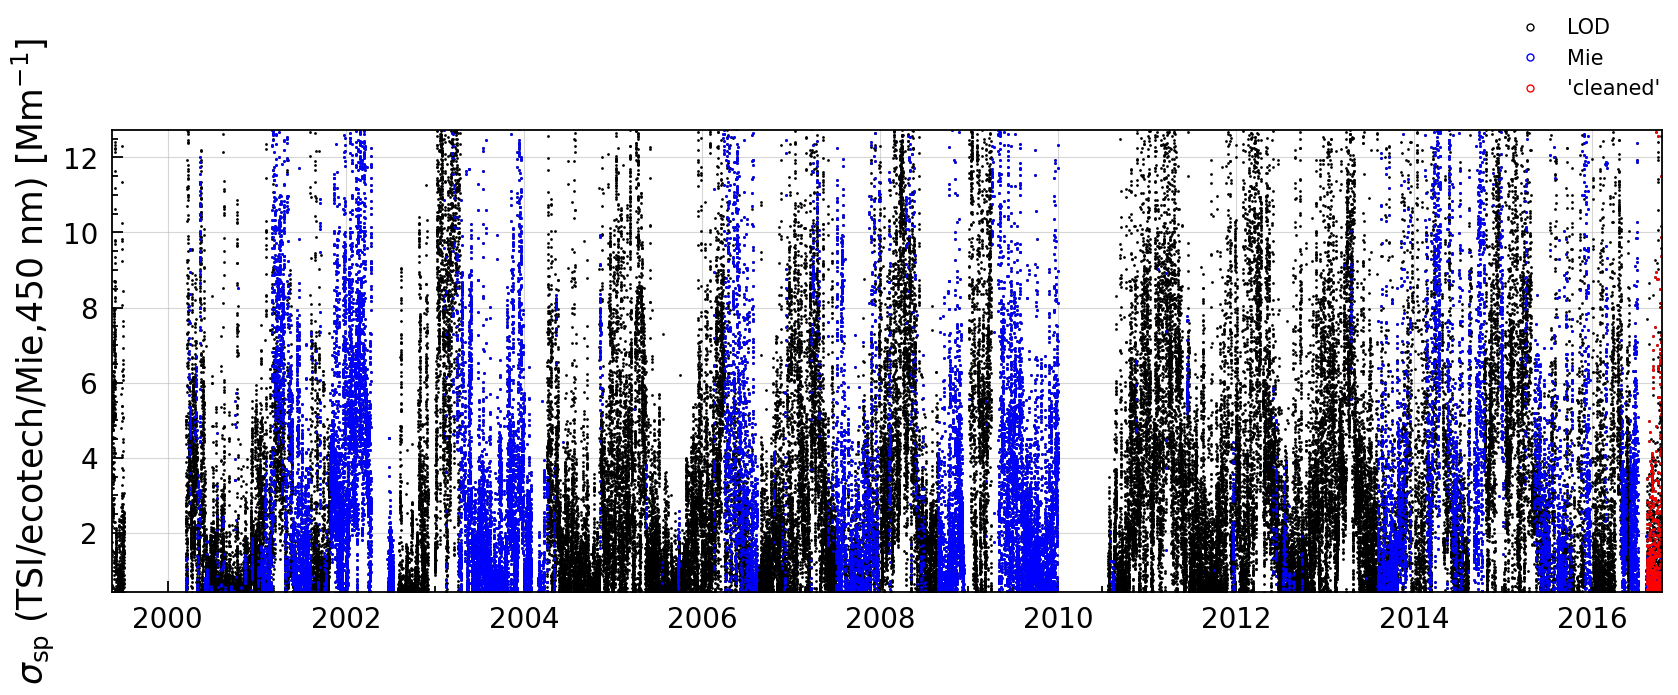

In [70]:
fig, ax = plt.subplots(figsize=(20,6))
basic_timeseries_ax(df_LOD_Mie, var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='LOD', 
                      startdate=df_LOD_Mie.index[0], enddate=date_newPSAP_ends, ax=ax)
basic_timeseries_ax(df_LOD_Mie[df_LOD_Mie.Mie == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='Mie', 
                      startdate=df_LOD_Mie.index[0], enddate=date_newPSAP_ends, c='b', ax=ax)
basic_timeseries_ax(df_LOD_Mie[df_LOD_Mie.std_cleaned_data == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', 
                      legendlabel="'cleaned'", 
                      startdate=df_LOD_Mie.index[0], enddate=date_newPSAP_ends, c='r', x_box=0.95, y_box=1.05, ax=ax)
plt.show()

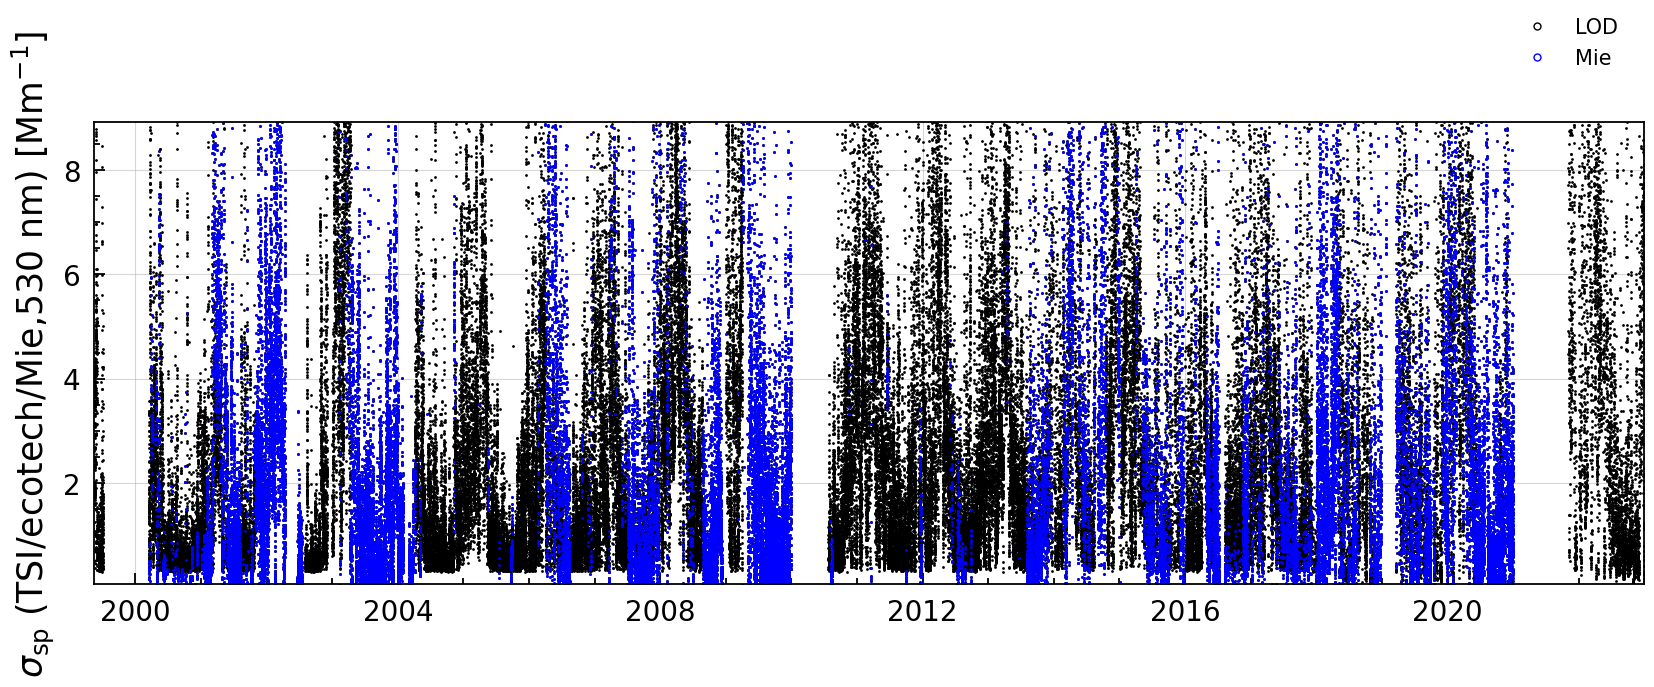

In [71]:
fig, ax = plt.subplots(figsize=(20,6))
basic_timeseries_ax(df_LOD_Mie, var='scat530',instrument='TSI/ecotech/Mie', wavelength='530', legendlabel='LOD', 
                      startdate=df_LOD_Mie.index[0], enddate=df_LOD_Mie.index[-1], ax=ax)
basic_timeseries_ax(df_LOD_Mie[df_LOD_Mie.Mie == 1], var='scat530',instrument='TSI/ecotech/Mie', wavelength='530', legendlabel='Mie', 
                      startdate=df_LOD_Mie.index[0], enddate=df_LOD_Mie.index[-1], c='b', ax=ax)
plt.show()

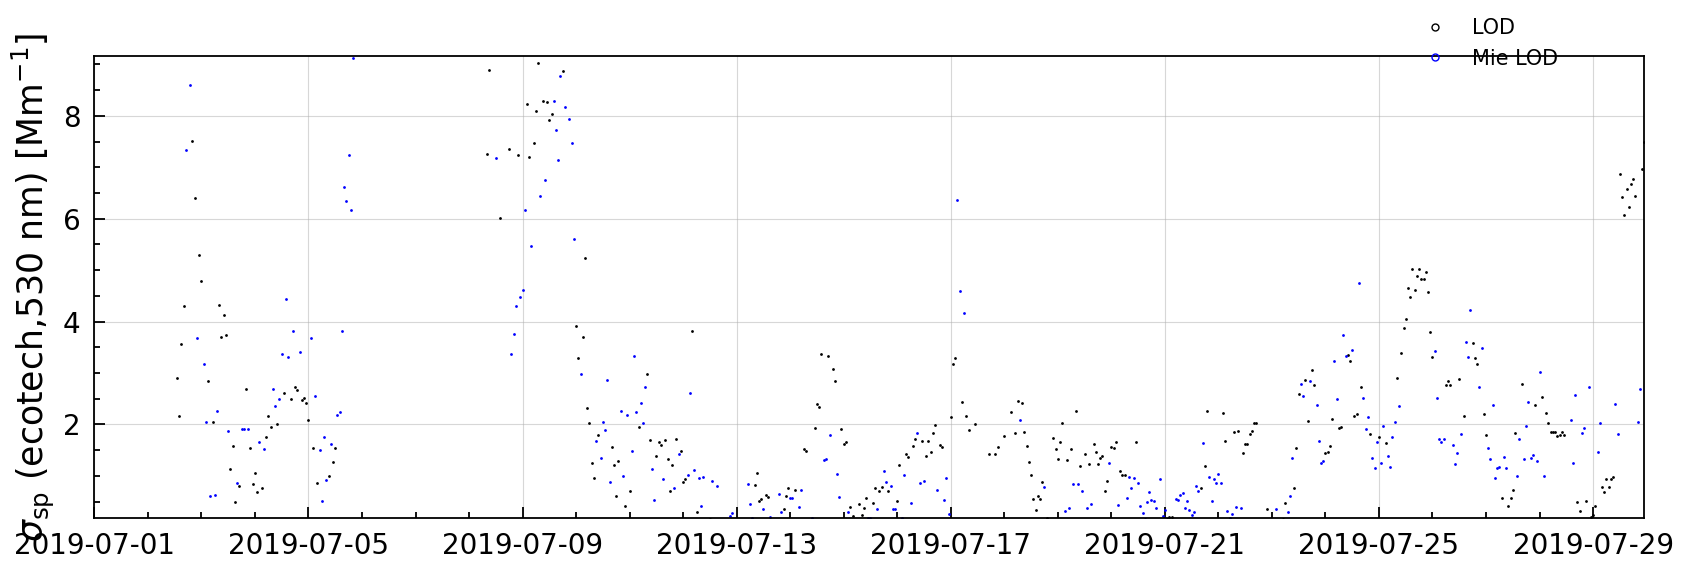

In [72]:
fig, ax = plt.subplots(figsize=(20,6))

df_LOD_Mie_july = df_LOD_Mie['2019-07-01':'2019-07-29'].copy()

basic_timeseries_ax(df_LOD_Mie_july[df_LOD_Mie_july.Mie == 0], var='scat530',instrument='ecotech', wavelength='530', 
                    legendlabel='LOD', startdate=df_LOD_Mie_july.index[0], 
                    enddate=df_LOD_Mie_july.index[-1], ax=ax)
basic_timeseries_ax(df_LOD_Mie_july[df_LOD_Mie_july.Mie == 1], var='scat530',instrument='ecotech', wavelength='530', 
                    legendlabel='Mie LOD', startdate=df_LOD_Mie_july.index[0], 
                    enddate=df_LOD_Mie_july.index[-1], c='b', ax=ax)
plt.show()

309


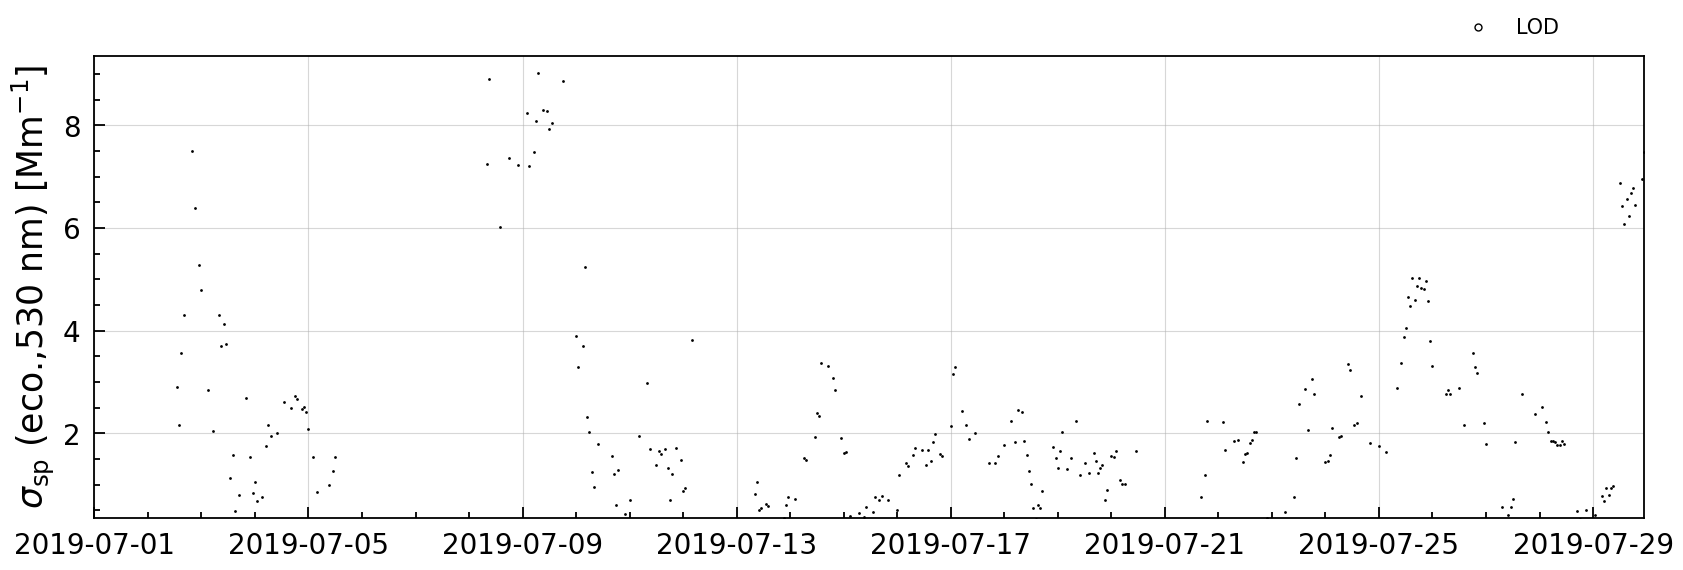

In [73]:
fig, ax = plt.subplots(figsize=(20,6))

df_LOD_Mie_july = df_LOD_Mie['2019-07-01':'2019-07-29'].copy()

df_LOD_Mie_july[df_LOD_Mie_july.Mie == 0]

print(len(df_LOD_Mie_july.loc[(df_LOD_Mie_july.Mie == 0), 'scat530'].dropna()))

basic_timeseries_ax(df_LOD_Mie_july[df_LOD_Mie_july.Mie == 0], var='scat530',instrument='eco.', wavelength='530', 
                    legendlabel='LOD', startdate=df_LOD_Mie_july.index[0], 
                    enddate=df_LOD_Mie_july.index[-1], ax=ax)
plt.show()

## noLOD:

In [ ]:
fig, ax = plt.subplots(figsize=(20,6))
basic_timeseries_ax(df_noLOD_Mie, var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='noLOD', 
                      startdate=df_noLOD_Mie.index[0], enddate=df_noLOD_Mie.index[-1], ymin=-5, ymax=30, ax=ax)
basic_timeseries_ax(df_noLOD_Mie[df_noLOD_Mie.Mie == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='Mie', 
                      startdate=df_noLOD_Mie.index[0], enddate=df_noLOD_Mie.index[-1], c='b', ymin=-5, ymax=30,  ax=ax)
plt.show()

## used for PSAP Corrections:
- greater than 0

In [75]:
df_LOD_Mie_cleaned = df_LOD_Mie[df_LOD_Mie.std_cleaned_data == 1]

In [76]:
df_noLOD_Mie = df_noLOD_Mie.copy()
df_noLOD_Mie.loc[:, 'std_cleaned_data'] = 0

frames = [df_noLOD_Mie, df_LOD_Mie_cleaned]
df_ = pd.concat(frames)
duplicate_indexes = fu.find_number_of_duplicate_indexs(df_)
df_notdup = df_.loc[~df_.index.isin(duplicate_indexes)]

df_dup = df_.loc[duplicate_indexes]
df_dup_not_Mie = df_dup[df_dup['Mie'] == 0]
df_dup_not_Mie_notstd_cleaned = df_dup_not_Mie[df_dup_not_Mie['std_cleaned_data'] == 0]

df_complete = pd.concat([df_notdup, df_dup_not_Mie])
df_complete = df_complete.sort_index()

Duplicate Rows except first occurrence based on all columns are :
7886


In [77]:
fu.save_df(df_complete, path=savepath, 
           name='df_scat_TSI_ecotech_Mie_used_to_correct_PSAP')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_scat_TSI_ecotech_Mie_used_to_correct_PSAP.dat


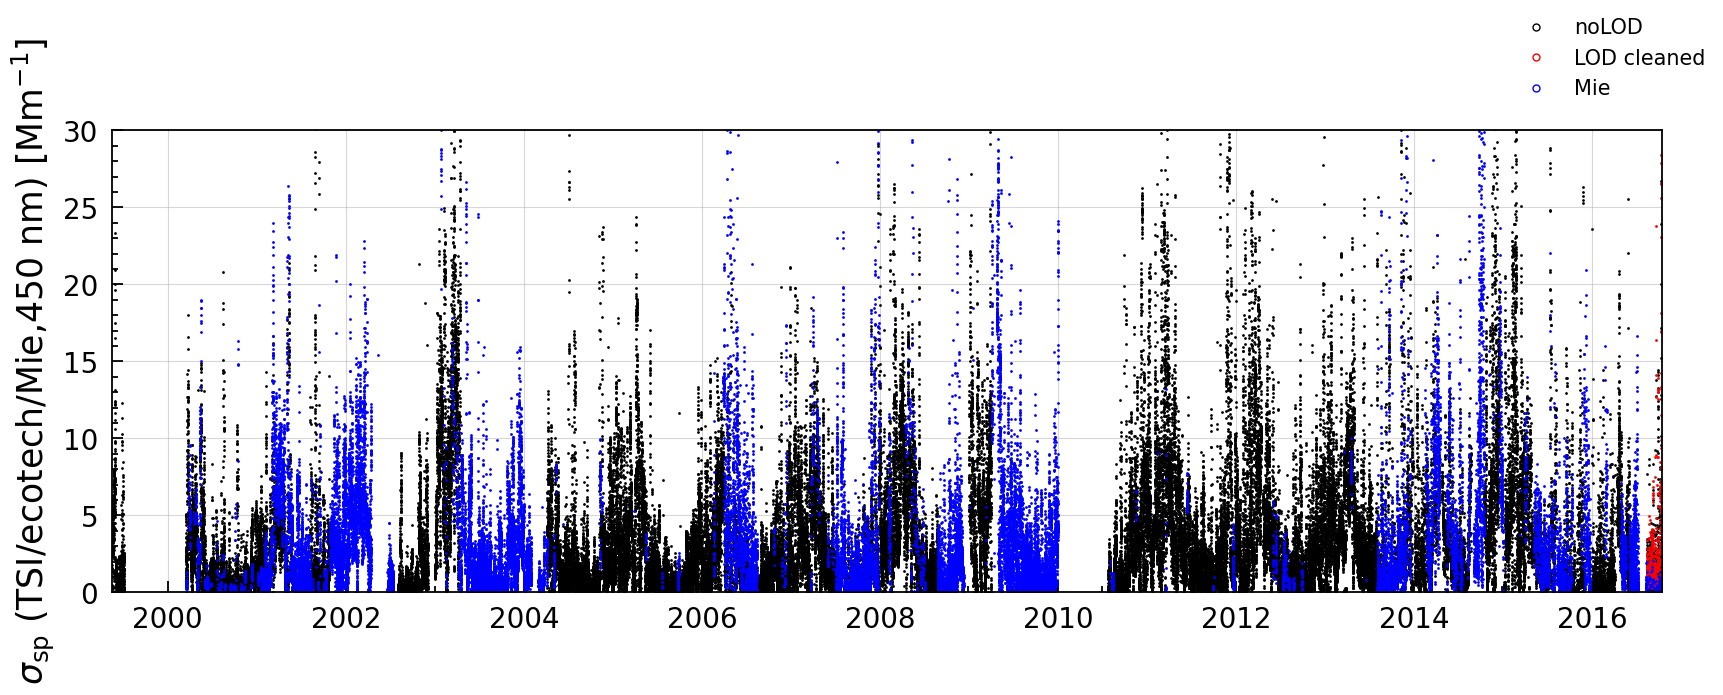

In [78]:
fig, ax = plt.subplots(figsize=(20,6))

df_obs = df_complete[df_complete.Mie == 0]
df_norm = df_obs[df_obs['std_cleaned_data'] == 0]
df_norm_cleaned = df_obs[df_obs['std_cleaned_data'] == 1]

basic_timeseries_ax(df_norm, var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='noLOD', 
                      startdate=df_complete.index[0], enddate=date_newPSAP_ends, ymin=0, ymax=30, ax=ax)
basic_timeseries_ax(df_norm_cleaned, var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', legendlabel='LOD cleaned', 
                      startdate=df_complete.index[0], enddate=date_newPSAP_ends, ymin=0, ymax=30, c='r', ax=ax)
basic_timeseries_ax(df_complete[df_complete.Mie == 1], var='scat450',instrument='TSI/ecotech/Mie', wavelength='450', 
                    legendlabel='Mie', startdate=df_complete.index[0], enddate=date_newPSAP_ends, c='b', ymin=0, ymax=30, 
                     x_box=0.90, y_box=1.05, ax=ax)
plt.show()

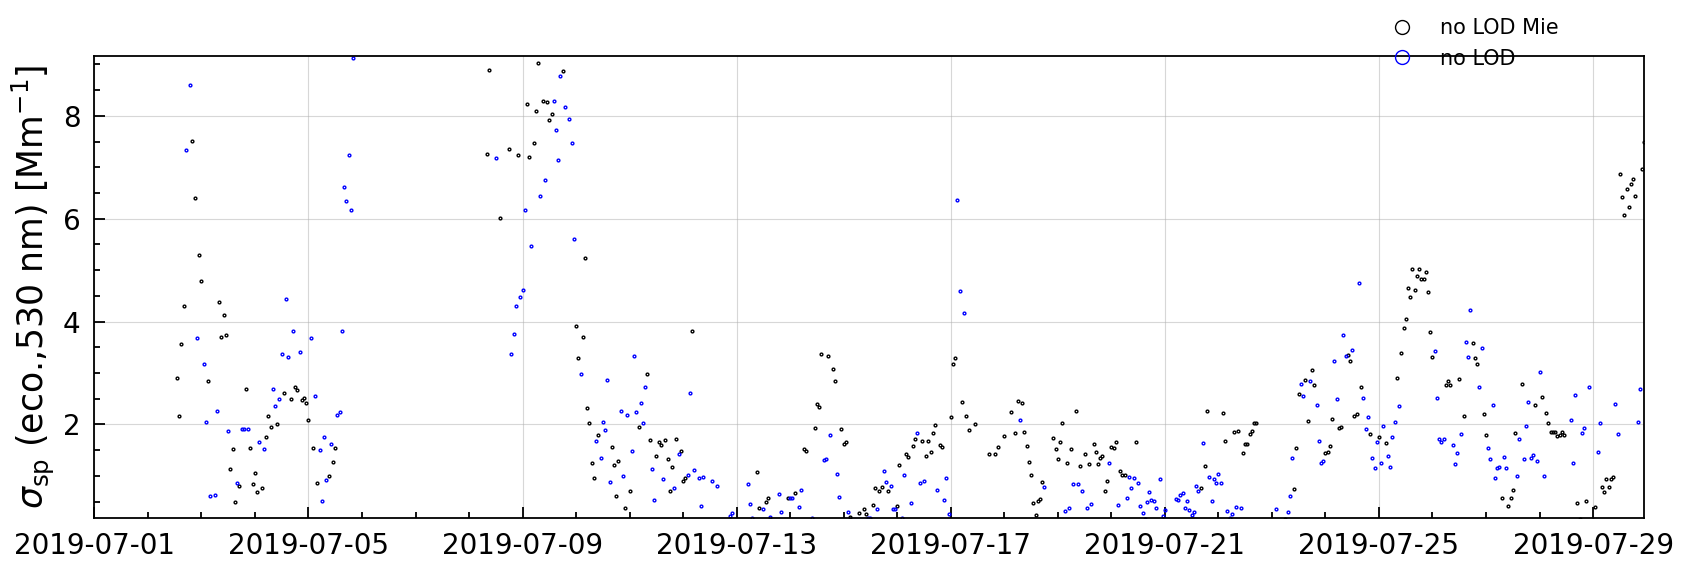

In [79]:
fig, ax = plt.subplots(figsize=(20,6))

df_noLOD_Mie_july = df_noLOD_Mie['2019-07-01':'2019-07-29'].copy()

basic_timeseries_ax(df_noLOD_Mie_july[df_noLOD_Mie_july.Mie == 0], var='scat530',instrument='eco.', wavelength='530', 
                    legendlabel='no LOD Mie', startdate=df_noLOD_Mie_july.index[0], 
                    enddate=df_noLOD_Mie_july.index[-1],  ms=2, ax=ax)
basic_timeseries_ax(df_noLOD_Mie_july[df_noLOD_Mie_july.Mie == 1], var='scat530',instrument='eco.', wavelength='530', 
                    legendlabel='no LOD', startdate=df_noLOD_Mie_july.index[0], 
                    enddate=df_noLOD_Mie_july.index[-1],  ms=2, c='b', ax=ax)
plt.show()

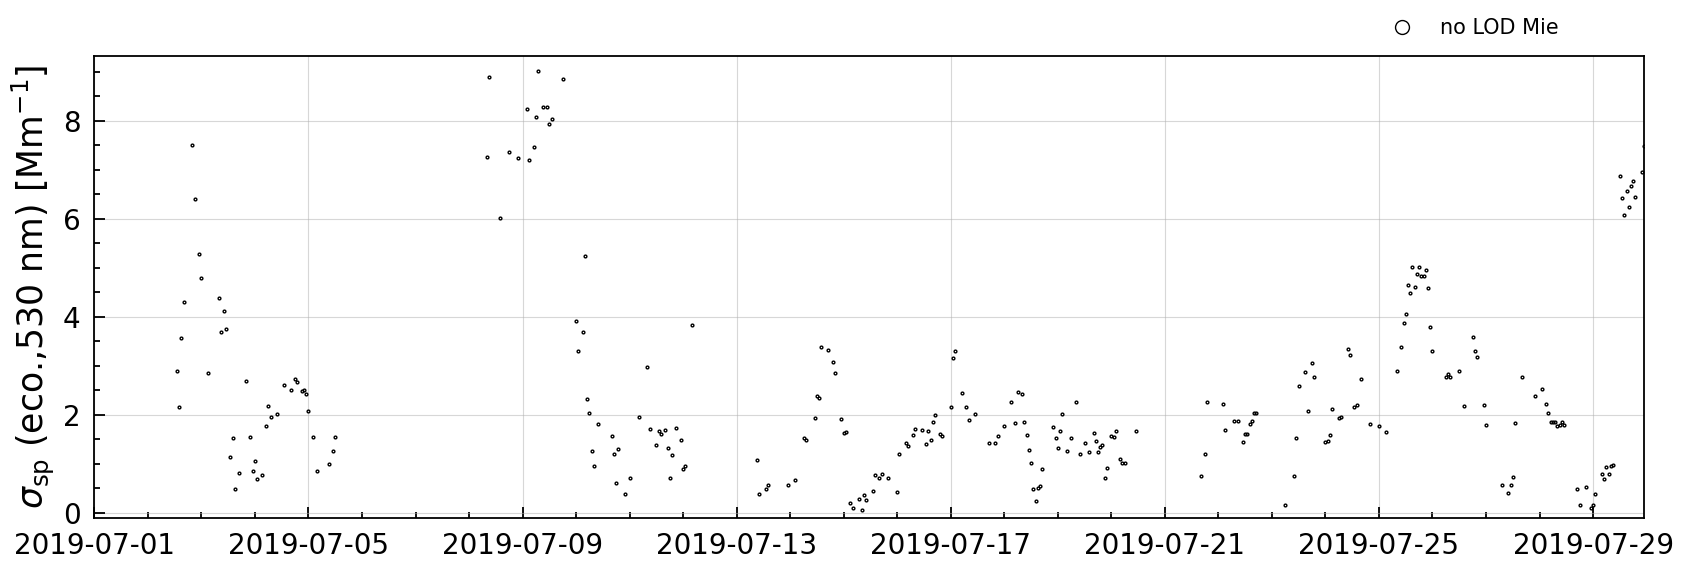

In [80]:
fig, ax = plt.subplots(figsize=(20,6))

df_noLOD_Mie_july = df_noLOD_Mie['2019-07-01':'2019-07-29'].copy()

basic_timeseries_ax(df_noLOD_Mie_july[df_noLOD_Mie_july.Mie == 0], var='scat530',instrument='eco.', wavelength='530', 
                    legendlabel='no LOD Mie', startdate=df_noLOD_Mie_july.index[0], 
                    enddate=df_noLOD_Mie_july.index[-1],  ms=2, c='k', ax=ax)

plt.show()

# Save

In [81]:
def rearrange_columns(df, columns):   
    df = df.reindex(columns, axis=1)
    return df

In [82]:
df_LOD_Mie = rearrange_columns(df_LOD_Mie, columns=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700', 
                             'bscat450','bscat525', 'bscat530', 'bscat550', 'bscat635', 'bscat637', 'bscat700',                         
                             'AE_450', 'AE_525', 'AE_550','AE_635', 'AE_700', 
                             'p_int', 'T_int', 'RH_int','std_cleaned_data','Mie'])

In [83]:
df_noLOD_Mie = rearrange_columns(df_noLOD_Mie, columns=['scat450', 'scat525', 'scat530', 'scat550', 'scat635', 'scat637', 'scat700', 
                             'bscat450','bscat525', 'bscat530', 'bscat550', 'bscat635', 'bscat637', 'bscat700',                         
                             'AE_450', 'AE_525', 'AE_550','AE_635', 'AE_700', 
                             'p_int', 'T_int', 'RH_int','std_cleaned_data','Mie'])

In [84]:
fu.save_df(df_LOD_Mie, path=savepath, 
           name='df_scat_TSI_ecotech_Mie_LOD')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_scat_TSI_ecotech_Mie_LOD.dat


# this is the final file used: 

In [85]:
fu.save_df(df_noLOD_Mie, path=savepath, 
           name='df_scat_TSI_ecotech_Mie_noLOD')

Save as: C:\Users\DominicHeslinRees\Documents\ACP_2023\Analysis\Neph\df_scat_TSI_ecotech_Mie_noLOD.dat
